In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
style.use('default')

np.set_printoptions(threshold=sys.maxsize)

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [2]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# State tomography analysis functions

Measurement occurs along 9 axes, each of which can give one of 4 values:

ZZ, ZX, ZY, XZ, XX, XY, YZ, YX, YY -> {00, 01, 10, 11}

In [3]:
meas_order = np.array(['ZZ', 'ZX', 'ZY', 'XZ', 'XX', 'XY', 'YZ', 'YX', 'YY'])
calib_order = np.array(['gg', 'ge', 'eg', 'ee'])

## Getting rho from meas counts

First random helper method stuff for pauli matrices and dealing with the measurement order

In [4]:
def pauli(i): return [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()][i]

def s2i(s): # string to pauli matrix index
    return int(np.char.find('IXYZ', s))

def i2s(i): # pauli matrix index to string
    return 'IXYZ'[i]

def order(S12): # given 2 pauli matrix names, get the index at which that combo (or equivalent data) was measured
    assert S12[0] in 'IXYZ'
    assert S12[1] in 'IXYZ'
    # for the purposes of getting counts, measuring in I basis and Z basis are interchangeable
    if S12[0] == 'I': S12 = 'Z'+S12[1]
    if S12[1] == 'I': S12 = S12[0]+'Z'
    return np.argwhere(meas_order == S12)[0][0]
# print(order('II'))

Define psi basis

In [5]:
"""
Define basis in to be used when doing MLE
"""
# 2 cardinal points on Bloch sphere for each measurement axis
# psiZ = [qt.basis(3,0), qt.basis(3,1)]
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

psi_basis = dict() # 36 elements
# psi_tensor = [psiZ[0], psiZ[0], psiZ[0], psiZ[0]]
for S12 in meas_order:
    S1, S2 = S12
    psi1 = psi_dict[S1]
    psi2 = psi_dict[S2]

    psi_basis.update({S12:[]})

    psi_basis[S12].append(qt.tensor(psi1[0], psi2[0])) # gg
    psi_basis[S12].append(qt.tensor(psi1[0], psi2[1])) # ge
    psi_basis[S12].append(qt.tensor(psi1[1], psi2[0])) # eg
    psi_basis[S12].append(qt.tensor(psi1[1], psi2[1])) # ee

    # print(psi_basis[S12])

psi_basis_flat = []
for S12 in meas_order:
    for psi in psi_basis[S12]:
        # measure in psi basis
        psi_basis_flat.append(psi)

# def get_psi_basis(qubits):
#     q0, q1 = qubits

#     for S12 in meas_order:
#         S1, S2 = S12
#         psi1 = psi[S1]
#         psi2 = psi[S2]

#         # gg
#         psi_tensor[q0] = psi1[0]
#         psi_tensor[q1] = psi2[0]
#         psi_basis.append(qt.tensor(*psi_tensor))

#         # ge
#         psi_tensor[q0] = psi1[0]
#         psi_tensor[q1] = psi2[1]
#         psi_basis.append(qt.tensor(*psi_tensor)) # ge

#         # eg 
#         psi_tensor[q0] = psi1[1]
#         psi_tensor[q1] = psi2[0]
#         psi_basis.append(qt.tensor(*psi_tensor)) # eg

#         # ee
#         psi_tensor[q0] = psi1[1]
#         psi_tensor[q1] = psi2[1]
#         psi_basis.append(qt.tensor(*psi_tensor)) # ee

#     return psi_basis

Convert single shot measurements into counts for each of the 9 measurement axes: 4x9=36 elements in the count array, then into the initial rho from experiment which will likely be unphysical.

In [6]:
"""
n should be length 4 array containing single shot counts of measuring 00, 01, 10, 11 for measurement along axes i, j
Converts n to Tij for use in the T^\dag T = rho matrix where measurement axes are S1 and S2: I, X, Y, Z
"""
def Tij(n, S1, S2):
    assert 0 <= S1 <= 3 # S1, S2 represent pauli matrix indices
    assert 0 <= S2 <= 3
    signs = [1]*4
    # eigenvalues of X, Y, Z are +/- 1, eigenvalues of I are +1
    if S1 > 0: signs[2] *= -1; signs[3] *= -1
    if S2 > 0: signs[1] *= -1; signs[3] *= -1
    return np.sum(np.multiply(signs, n))


In [7]:
h2 = -7/2*qt.tensor(qt.sigmaz(), qt.qeye(2)) - 9/2*qt.tensor(qt.qeye(2), qt.sigmaz())
print(h2.full())
evals = h2.eigenenergies()
print(h2.eigenstates())
print(evals - evals[0])

h2 = -7/2*qt.tensor(qt.sigmaz(), qt.qeye(2)) - 9/2*qt.tensor(qt.qeye(2), qt.sigmaz()) + 3/2*(qt.tensor(qt.sigmaz(), qt.sigmaz()))
print(h2.full())
evals = h2.eigenenergies()
print(h2.eigenstates())
print(evals - evals[0])

[[-8.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  8.+0.j]]
(array([-8., -1.,  1.,  8.]), array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[1.]
        [0.]
        [0.]
        [0.]]                                                             ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.]
        [0.]
        [1.]
        [0.]]                                                             ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.]
        [1.]
        [0.]
        [0.]]                                                             ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.]
        [0.]
        [0.]
        [1.]]                                                        

In [8]:
"""
Construct rho by adding together Tij for each of the 4^2 = 16 combinations of tensor product of 2 Pauli matrices
"""
def rho_from_counts(n):
    rho = 0*qt.tensor(qt.qeye(2), qt.qeye(2))
    for i in range(4): # loop over pauli matrices for qubit 1
        for j in range(4): # loop over pauli matrices for qubit 2
            o = order(i2s(i) + i2s(j)) # get the right 4 elements in the n matrix
            # print(i2s(i), i2s(j), Tij(n[4*o:4*(o+1)], i, j))
            rho += Tij(n[4*o:4*(o+1)], i, j) * qt.tensor(pauli(i), pauli(j))
    rho = rho.unit() # normalize
    rho = rho.tidyup(1e-10) # remove small elements
    rho = rho.full()

    # # expand rho into a 4 qubit subspace
    # q0, q1 = qubits
    # if q0 > q1: rho = qt.qip.gates.swap(N=4, targets=qubits).full() @ rho
    # id = qt.qeye(2)
    # tensor = [id, id, id]
    # tensor[min((q0, q1))] = rho
    # rho = qt.tensor(*tensor)
    # if max((q0, q1)) - min((q0, q1)) > 1:
    #     rho = qt.qip.gates.swap(N=4, targets=[min((q0, q1)) + 1, max((q0, q1))])

    return rho

### Generate test data

In [9]:
def generate_counts(rho_id, n_tot, psi_basis_flat=None, evol_mats=None, noise=1.0):
    assert psi_basis_flat or evol_mats
    
    if psi_basis_flat is not None:
        print('Generating with psi basis')
        n = []
        # psi_basis = get_psi_basis(qubits)
        for psi in psi_basis_flat:
            # measure in psi basis
            n.append(n_tot * (psi.dag() * rho_id * psi).tr())
        n = np.reshape(np.array(n), (len(psi_basis.keys()), 4))
    
    elif evol_mats is not None:
        print('Generating with evol mats')
        evals, evecs = np.linalg.eig(rho_id)
        evals = np.real(evals)
        n_evol = []
        for basis in meas_order:
            evol_mat = evol_mats[basis] # evol_mat sends each psi_ij to the evolved ket
            n_basis_th = np.zeros(4)
            for i in range(4):
                evec_evol = evol_mat @ evecs.T[i]
                if evals[i] > 1e-12: n_basis_th += evals[i] * n_tot * abs(evec_evol)**2 # add counts weighted by eval
            n_evol.append(n_basis_th)
        n_evol = np.array(n_evol)
        return n_evol

    # introduce gaussian noise
    if noise is not None:
        for n_psi in n:
            n_meas = sum(n_psi)
            new_n3 = -1
            while new_n3 < 0:
                new_n012 = np.random.normal(loc=n_psi[:3], scale=noise*np.sqrt(n_psi[:3]))
                # preserve original total count per measurement
                new_n3 = n_meas - sum(new_n012)
            n_psi[:3] = np.round(new_n012)
            n_psi[3] = np.round(new_n3)
    return n

### Error mitigation
Readout error means state prepared in |gg> will also have counts in |ge>, |eg>, |ee>; apply inverse of confusion matrix to correct. See qiskit measurement error mitigation procedure: [https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html)

maybe need to do something about fixing negative counts, but for now I will not. it should be automatically resolved in the MLE.

In [10]:
def correct_readout_err(n, n_conf):
    conf_mat = np.array(n_conf, dtype=float)
    for r, row in enumerate(conf_mat):
        conf_mat[r] /= sum(row) # normalize so counts for each state prep sum to 1
    conf_mat = np.transpose(conf_mat) # want counts for each state prep on columns
    conf_mat_inv = np.linalg.inv(conf_mat)
    # C_id = invM . C_noisy
    n = np.array(n, dtype=float)
    for r in range(len(n)):
        n[r] = (conf_mat_inv @ n[r].T).T
    return np.around(n, decimals=5)

In [11]:
def fix_neg_counts(counts):
    counts = np.array(counts)
    assert len(counts.shape) == 2 # 2d array

    for i_n, n in enumerate(counts):
        while len(n[n<0]) > 0: # repeat while still has neg counts
            assert sum(n) > 0, 'Negative sum of counts'
            neg_indices = np.where(n<0)[0]
            neg_vals = n[n<0]
            len_pos = len(n) - len(neg_vals)
            n += sum(neg_vals)/len_pos # redistribute the negative counts over all the positive elements evenly
            for i in neg_indices:
                n[i] = 0

        counts[i_n] = np.round(n)
    return counts

## Fix rho to a physical density matrix using MLE
Initial counts will be unphysical. Use MLE to map counts to a physical density matrix.

### Cholesky-esque decomposition functions

In [12]:
# Modification of np.diag_indices to allow off diagonal entries
# n = dim, k < 0 = lower diagonals, k > 0 = upper diagonals
def diag_indices_k(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0: return rows[-k:], cols[:k]
    elif k > 0: return rows[:-k], cols[k:]
    else: return rows, cols

def T_flat2mat(t):
    # T_mat = []
    # T_mat.appen(np.array([t[0],           0,              0,               0]))
    # T_mat.append(np.array([t[4] +1j*t[5],  t[1],           0,               0]))
    # T_mat.append(np.array([t[10]+1j*t[11], t[6]+1j*t[7],   t[2],            0]))
    # T_mat.append(np.array([t[14]+1j*t[15], t[12]+1j*t[13], t[8]+1j*t[9], t[3]]))
    d = int(np.sqrt(len(t)))
    t_complex = np.zeros(int(d + (len(t)-d)/2), dtype=complex)
    t_complex[:d] = t[:d]
    for i in range(d, len(t_complex)):
        t_complex[i] = t[d + (i-d)*2] + 1j*t[d + (i-d)*2 + 1]
    T_mat = np.zeros(shape=(d,d), dtype=complex)
    start_i = 0
    for k in range(d):
        T_mat[diag_indices_k(T_mat, -k)] = t_complex[start_i:start_i+(d-k)]
        start_i += d - k
    return np.array(T_mat)


USE THESE (need to handle divide by 0 errors, which the more general method does not handle)

This is taken from [James et al. 2001](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.64.052312), eq. 4.6.

In [13]:
def det_ij(rho, i, j):
    M = np.delete(rho, i, axis=0)
    M = np.delete(M, j, axis=1)
    return np.linalg.det(M)

def det_ijkl(rho, i, j, k, l):
    M = np.delete(rho, [i,k], axis=0)
    M = np.delete(M, [j,l], axis=1)
    return np.linalg.det(M)

def t_from_rho(rho):
    t = []
    det = np.linalg.det(rho)
    det00 = det_ij(rho, 0, 0)
    det01 = det_ij(rho, 0, 1)
    det0011 = det_ijkl(rho, 0, 0, 1, 1)
    det0012 = det_ijkl(rho, 0, 0, 1, 2)
    det0112 = det_ijkl(rho, 0, 1, 1, 2)
    # ensure no divide by 0 errors since this algo is intended for positive definite matrices
    # if det == 0: det = 1e-10
    # if det00 == 0: det00 = 1e-10
    # if det0011 == 0: det0011 = 1e-10
    # if det0012 == 0: det0012 = 1e-10
    # if det0112 == 0: det0112 = 1e-10
    rho33 = rho[3,3]
    # if rho33 == 0: rho33 = 1e-10
    t = [
        0 if det00 == 0 else np.sqrt(det/det00),
        0 if det0011 == 0 else np.sqrt(det00/det0011),
        0 if rho33 == 0 else np.sqrt(det0011/rho33),
        np.sqrt(rho[3,3])
        ]
    t56 = 0 if det00*det0011 == 0 else det01/np.sqrt(det00*det0011)
    t.extend([np.real(t56), np.imag(t56)])

    t78 = 0 if rho33*det0011 == 0 else det0012/np.sqrt(rho33*det0011)
    t.extend([np.real(t78), np.imag(t78)])

    t910 = 0 if rho33 == 0 else rho[3,2]/np.sqrt(rho33)
    t.extend([np.real(t910), np.imag(t910)])

    t1112 = 0 if rho33*det0011 == 0 else det0112/np.sqrt(rho33*det0011)
    t.extend([np.real(t1112), np.imag(t1112)])

    t1314 = 0 if rho33 == 0 else rho[3,1]/np.sqrt(rho33)
    t.extend([np.real(t1314), np.imag(t1314)])

    t1516 = 0 if rho33 == 0 else rho[3,0]/np.sqrt(rho33)
    t.extend([np.real(t1516), np.imag(t1516)])

    assert(len(t)==16)
    return np.real(np.array(t)) # take the real since rho may be slightly non-positive semi definite, so det(rho) may be slightly negative

def rho_from_t(t):
    T = T_flat2mat(t)
    rho = T.conj().T @ T
    return rho / np.trace(rho)

Not using this

Cholesky-Banachiewicz algorithm - valid for positive definite matrices, so need to ensure no divide by 0 errors. This doesn't seem to work?

In [14]:
# def t_from_rho(rho):
#     t = []
#     T = np.zeros(shape=np.shape(rho))
#     d = np.shape(rho)[0]
#     for i in range(d):
#         for j in range(i+1):
#             sum = 0
#             for k in range(j):
#                 sum += T[i, k] * T[j, k]
#             if i == j: T[i, i] = np.sqrt(rho[i, i] - sum)
#             else:
#                 Tjj = T[j, j]
#                 if Tjj == 0: Tjj = 1e-10
#                 T[i, j] = (rho[i, j] - sum) / Tjj
#     t = np.diagonal(T)
#     for k in range(1, d):
#         t_complex = np.diag(T, k=-k)
#         for t_i in t_complex:
#             t = np.append(t, [np.real(t_i), np.imag(t_i)])
#     assert(len(t)==16)
#     return np.real(t)
    
# def rho_from_t(t):
#     T = T_flat2mat(t)
#     rho = T @ T.conj().T
#     return rho / np.trace(rho)

### ZZ correction
Instead of using bare psis in MLE, introduce ZZ coupling in Hamiltonian and use the pulse shapes used in the tomography pulse sequence to simulate the expected final state of each of the psis. Then use these corrected "evolution states" to match the MLE.

Note: uses QSwitch and related classes

In [15]:
"""
Get effective drive rate in GHz
"""
sigma_n = 4 # total number of sigmas in gaussian
def amp_eff(sigma_ns, sigma_n=sigma_n):
    return 1/4 / (sigma_ns * np.sqrt(2*np.pi) * sp.special.erf(sigma_n/2 / np.sqrt(2)))

# Return what phi should be when driving in the other quadrature, i.e. cos(wt+phi) <-> sin(wt-phi)
def phase_to_other_drive(phase):
    return np.pi - phase

In [16]:
def get_evol_mats(qubits, qfreqs, ZZs, pulse_dict, dt=0.01):
# def get_evol_mats(qubits, qfreqs, alphas, pulse_dict):
    assert len(pulse_dict.items()) == len(meas_order)
    # print("WARNING: current gain to freq conversion for rfsoc is very fake!", flush=True)
    evol_mats = dict()
    device = QSwitch(qubit_freqs=qfreqs, ZZs=ZZs, cutoffs=[2,2], useZZs=True, is2Q=True)

    # Get the pi/2 pulse lengths for both qubits
    pulse_cfgs_XX = pulse_dict['XX']
    pi2_lens = [0]*2
    pi2_types = [None]*2
    for pulse_name, pulse_cfg in pulse_cfgs_XX.items():
        if pulse_cfg['flag'] != 'ZZcorrection': continue
        drive_qubit = int(pulse_cfg['name'][-1]) # get the qubit number
        assert drive_qubit in qubits

        # convert drive qubit out of 4 to drive qubit in a 2Q Hamiltonian
        drive_qubit = qubits.index(drive_qubit)
        pi2_types[drive_qubit] = pulse_cfg['type']
        if pi2_types[drive_qubit] == 'gauss':
            pulse_len = pulse_cfg['sigma']
        elif pi2_types[drive_qubit] == 'const':
            pulse_len = pulse_cfg['length']
        pi2_lens[drive_qubit] = soc.cycles2us(pulse_len, gen_ch=pulse_cfg['ch']) * 1e3
    assert 0 not in pi2_lens

    for basis, pulse_cfgs in tqdm(pulse_dict.items()):
        # print(basis)
        seq = PulseSequence()

        # print('all pulse_cfgs for basis', basis, pulse_cfgs)
        for drive_qubit in (0, 1):
            if basis[drive_qubit] == 'Z':
                device.add_precise_pi_pulse(seq, 'gg', 'gg', amp=0, drive_qubit=drive_qubit, wd=-1, phase=0, type=pi2_types[drive_qubit], t_pulse=pi2_lens[drive_qubit], t_offset=0, sigma_n=sigma_n)
                continue

            # Find the appropriate pulse cfg for the pulse
            for pulse_name, pulse_cfg in pulse_cfgs.items():
                # print('flag', pulse_cfg['flag'])
                if pulse_cfg['flag'] != 'ZZcorrection': continue
                # print(pulse_name)
                pulse_qubit = int(pulse_cfg['name'][-1]) # get the qubit number
                assert pulse_qubit in qubits
                # convert drive qubit out of 4 to drive qubit in a 2Q Hamiltonian, proceed if this is the drive qubit we want
                if qubits.index(pulse_qubit) != drive_qubit: continue

                ch = pulse_cfg['ch']
                freq = pulse_cfg['freq_MHz']
                freq += 4000 if freq < 1000 else 0
                wd = 2*np.pi * freq * 1e-3
                # phase = pulse_cfg['phase_deg'] * np.pi/180
                phase = phase_to_other_drive(pulse_cfg['phase_deg'] * np.pi/180) # convert from the sin wavefunction used in definition of rfsoc drive to the cos wavefunction used for simulations
                type = pulse_cfg['type']

                pulse_length = pi2_lens[drive_qubit] # ns
                assert pulse_length > 1 # 1 ns
                amp = amp_eff(pulse_length, sigma_n=sigma_n)
                # print(pulse_length, amp)

                new_state = 'gg'
                new_state = new_state[:drive_qubit] + 'e' + new_state[drive_qubit+1:]
                # print(new_state)
                device.add_precise_pi_pulse(seq, 'gg', new_state, amp=amp, drive_qubit=drive_qubit, wd=wd, phase=phase, type=type, t_pulse=pulse_length, t_offset=0, sigma_n=sigma_n)

                # # print('all params')
                # print('fd', wd/2/np.pi)
                # print('pulse length', pulse_length)
                # print('amp', amp)
                # print('phase rad', phase)
                # print('drive q', drive_qubit)

        total_length = sum(seq.get_pulse_lengths())
        nsteps = int(total_length // dt + 1)
        times = np.linspace(0, total_length, num=nsteps)

        # envelope_seq = seq.get_envelope_seq()
        # pulse_amps = seq.get_pulse_amps()
        # print(seq.get_pulse_freqs(), '(GHz)')
        # print(seq.get_pulse_amps(), '(GHz)')
        # print(seq.get_pulse_lengths(), '(ns)')
        # print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')
        # for i in range(len(envelope_seq)):
        #     plt.plot(times, [pulse_amps[i]*envelope_seq[i](t)*1e3 for t in times], label=f'Pulse {i}')
        # plt.xlabel('Time (ns)')
        # plt.ylabel('Drive Amplitude (MHz)')
        # plt.title(f'Pulse Sequence {basis}')
        # plt.legend()
        # plt.show()

        # pulse_index = np.where(np.array(meas_order)==str(basis))[0][0]
        # psi_basis = get_psi_basis(qubits)

        # print('total length', total_length)
        evol_mats.update({basis:[]})
        # for psi0 in psi_basis[basis]:
        #     times = [0, total_length]
        #     evol_mats[basis].append(device.evolve(psi0, seq, times, nsteps=100000, use_str_solve=False, progress=False)[-1])
        #     print('basis', basis, 'overlap', abs(psi0.overlap(evol_mats[basis][-1]))**2)
        for state0 in range(2):
            for state1 in range(2):
                psi0 = qt.ket(str(state0)+str(state1))
                evol_ket_all_times = device.evolve_array(psi0, seq, times, nsteps=100000, use_str_solve=False, progress=False)
                # print('basis', basis, 'overlap', abs(psi_basis[basis][state0*2+state1].overlap(evol_ket))**2)

                evol_ket = device.evolve_unrotate(times=[times[-1]], result=[evol_ket_all_times[-1]], progress=False)[-1]
                # evol_ket = evol_ket_all_times[-1]

                # for ref_state in ['gg', 'ge', 'eg', 'ee']:
                #     state = device.state(ref_state)
                #     print(ref_state, 'prob', np.abs(state.overlap(evol_ket))**2)

                evol_mats[basis].append(evol_ket.unit())
                # print(qt.ket2dm(evol_ket).unit())
                # evol_mats[basis].append(evol_ket.full().transpose())
        evol_mats[basis] = np.hstack(evol_mats[basis])
        
        # envelope_seq = seq.get_envelope_seq()
        # pulse_amps = seq.get_pulse_amps()
        # print(seq.get_pulse_freqs(), '(GHz)')
        # print(seq.get_pulse_lengths(), '(ns)')
        # print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')
        # plot_times = np.linspace(0, total_length, 100)
        # for i in range(len(envelope_seq)):
        #     plt.plot(plot_times, [pulse_amps[i]*envelope_seq[i](t)*1e3 for t in plot_times], label=f'Pulse {i}')
        # plt.xlabel('Time (ns)')
        # plt.ylabel('Drive Amplitude (MHz)')
        # plt.title('Pulse Sequence')
        # plt.legend()
        # plt.show()

    return evol_mats

### MLE functions

In [17]:
def run_MLE_standard(n, rho_guess=None, rho_id=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    # psi_basis = get_psi_basis(qubits)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(psi_basis_flat, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        # return np.log(val)
        return val
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [18]:
def run_MLE_ZZ(n, evol_mats, rho_guess=None, rho_id=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = (rho_id.full() + rho_from_counts(n))/2
    n_tot = sum(n)
    # psi_basis = get_psi_basis(qubits)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        # for psi, n_val in zip(evol_mats, n.flatten()):
        #     psi = psi.full()
        #     proj = (psi.conj().T @ rho @ psi)[0][0]
        #     if proj != 0:
        #         val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        # # return np.log(val)
        # return val

        evals, evecs = np.linalg.eig(rho)
        evals = np.real(evals)
        n_evol = []
        for basis in meas_order:
            evol_mat = evol_mats[basis] # evol_mat sends each psi_ij to the evolved ket
            n_basis_th = np.zeros(4)
            for i in range(4):
                if evals[i] < 1e-12: continue
                evec_evol = evol_mat @ evecs.T[i]
                n_basis_th += evals[i] * n_tot * abs(evec_evol)**2 # add counts weighted by eval
            n_evol.append(n_basis_th)
        n_evol = np.array(n_evol)

        for n_th, n_expt in zip(n_evol.flatten(), n.flatten()):
            if n_th != 0: val += abs((n_th - n_expt)**2 / n_th)
        return val

    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [19]:
def run_MLE(n, ZZ_correction=False, evol_mats=None, rho_guess=None, rho_id=None, method='L-BFGS-B'):
    if ZZ_correction: return run_MLE_ZZ(n, evol_mats, rho_guess=rho_guess, rho_id=rho_id, method=method)
    else: return run_MLE_standard(n, rho_guess=rho_guess, rho_id=rho_id, method=method)

Optimize over virtual Z gates on ideal rho 

In [20]:
def z_gate_2q(phi1, phi2):
    return qt.tensor(qt.qip.operations.gates.rz(phi1), qt.qip.operations.gates.rz(phi2)) 

# The experimental density matrix from MLE may be offset from the simulated/ideal density matrix by a Z gate - due to different pulse times, ac stark shifts, etc.
def opt_virtualZ_MLE(rho_MLE, rho_id, nphi=100):
    phis = np.linspace(0, 2*np.pi, nphi)
    best_fid = 0
    best_phis = [0, 0]
    best_rho_id = rho_id
    for phi1 in tqdm(phis):
        for phi2 in phis:
            z_phi12 = z_gate_2q(phi1, phi2)
            rho_id_rot = (z_phi12*rho_id*z_phi12.dag()).unit()
            fid = qt.fidelity(rho_MLE, rho_id_rot)**2
            # print(fid)
            if fid > best_fid:
                best_fid = fid
                best_phis = [phi1*180/np.pi, phi2*180/np.pi]
                best_rho_id = rho_id_rot
    print(f'Improved fidelity by (%) {(best_fid - qt.fidelity(rho_MLE, rho_id)**2)*100}')
    return best_rho_id, best_phis, best_fid

# Plotting functions

In [21]:
# from qutip.visualization import hinton

In [22]:
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title, fontsize=24)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels, fontsize=24)
    plt.yticks(np.arange(len(mat)), labels, fontsize=24)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=22)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, ticks=[-cmax, 0, cmax])
    cbar.ax.tick_params(labelsize=20)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_MLE, rho_id=None, title=None, cmax=None, savetitle=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    if savetitle is not None: plt.style.use('dark_background')

    labels = ["00", "01", "10", "11"]
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(15, 12))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    plt.suptitle(title, fontsize=24)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_MLE), np.imag(rho_MLE), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_MLE), ax=ax1, title="Re[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_MLE), ax=ax2, title="Im[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
    plt.show()

def show_plot_rho_3d(rho_MLE, rho_id=None, title='', zmin=None, zmax=None, width=0.75, elev=30, azim=-20, savetitle=None):
    if savetitle is not None: plt.style.use('dark_background')
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    labels = ["00", "01", "10", "11"]
    _xx, _yy = np.meshgrid(np.arange(4), np.arange(4))
    x, y = _xx.ravel(), _yy.ravel()
    if zmax is None: zmax = np.max(np.array([np.real(rho_MLE), np.imag(rho_MLE), np.real(rho_id), np.imag(rho_id)]))
    if zmin is None: zmin = np.min((0, np.min(np.array([np.real(rho_MLE), np.imag(rho_MLE), np.real(rho_id), np.imag(rho_id)]))))

    ax1.view_init(elev=elev, azim=azim)
    ax1.set_xticks(np.arange(4), minor=False)
    ax1.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax1.set_yticks(np.arange(1, 5, 1), minor=False)
    ax1.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax1.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.real(rho_id).flatten(), edgecolor='k', alpha=0)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.real(rho_MLE).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax1.set_zlim(zmin, zmax)
    ax1.set_title("Re[$\\rho$]", fontsize=20)

    ax2.view_init(elev=elev, azim=azim)
    ax2.set_xticks(np.arange(4), minor=False)
    ax2.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax2.set_yticks(np.arange(1, 5, 1), minor=False)
    ax2.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax2.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.imag(rho_id).flatten(), edgecolor='k', alpha=0)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.imag(rho_MLE).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax2.set_zlim(zmin, zmax)
    ax2.set_title("Im[$\\rho$]", fontsize=20)

    plt.suptitle(title, fontsize=22)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
    plt.show()

# Run experiment and analysis

In [23]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.DONOTUSE_ramsey_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qub

In [24]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'\\'+filename
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [25]:
# expt_path = os.getcwd()+'\data'
# expt_path = 's:\\Connie\\experiments\\20220430_2Transmon\\data'
# expt_path = os.getcwd()+'\\data_220712'
# expt_path=os.getcwd()+'\data\data_221215'
expt_path=os.getcwd()+'\data\data_230217'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_230217


In [26]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688_reset.yml'
config_path = os.getcwd() + '\\' + config_file

# config_file = 'config.yml'
# config_path = 's:\\Connie\\experiments\\20220430_2Transmon\\' + config_file

print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688_reset.yml


In [27]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [28]:
im = InstrumentManager()

In [28]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 5925000000.0
set power to 7.0


In [29]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_sg_mux4_v2 - tProc output

## Run experiment and acquire data

### Test 2Q tomo

In [30]:
tomo_qubits = [3, 1] # which qubit/resonator we want to probe

{'device': {'qubit': {'T1': [30, 65, 50, 150], 'f_ge': [4140.533743739655, 3463.728373773443, 4800.1199711068375, 4415.307783242773], 'f_Q1_ZZ': [3458.5532077647345, 0, 3462.6479880140837, 3462.424516152739], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2686.2, 0, 2026.1, 2411.05], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [23010, 22828, 22631, 25187], 'sigma': [0.02578, 0.015, 0.02291, 0.01506], 'type': 'gauss'}, 'pi_ef': {'gain': [24185, 11000, 21496, 24157], 'sigma': [0.02354, 0.02673, 0.01816, 0.01912], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25490, 0, 24057, 21583], 'sigma': [0.015, 0

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)


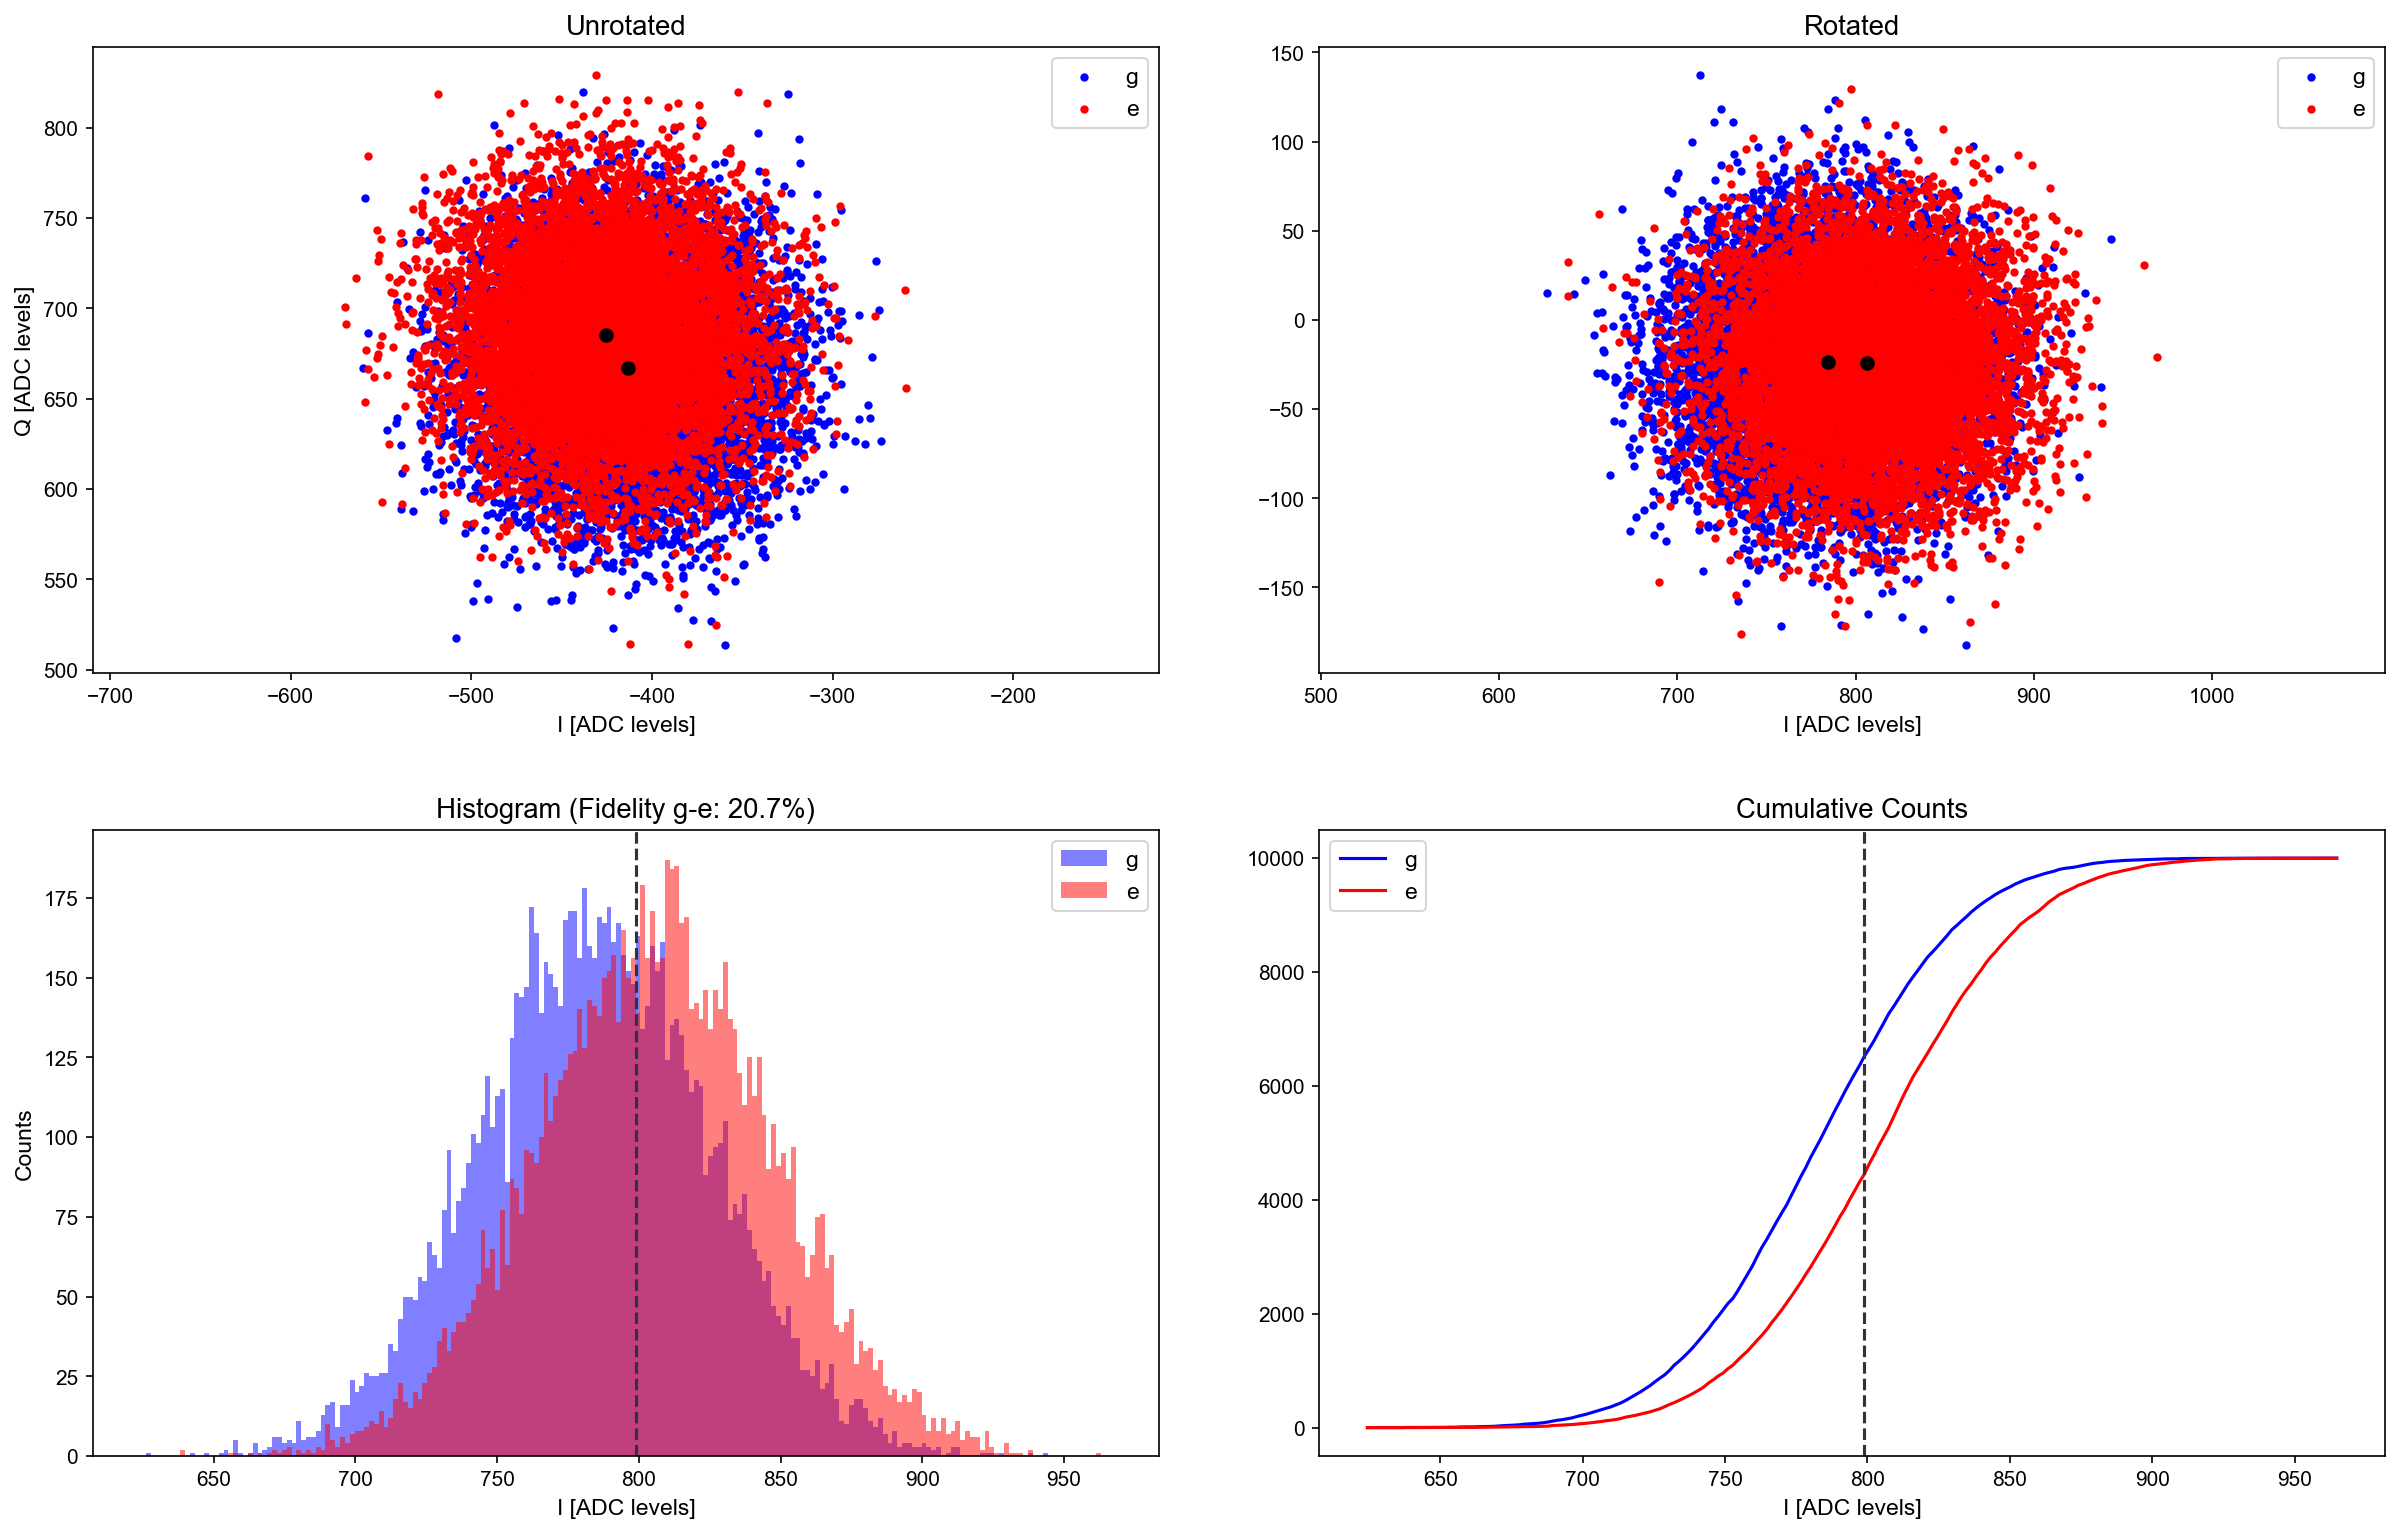

Qubit  (1)


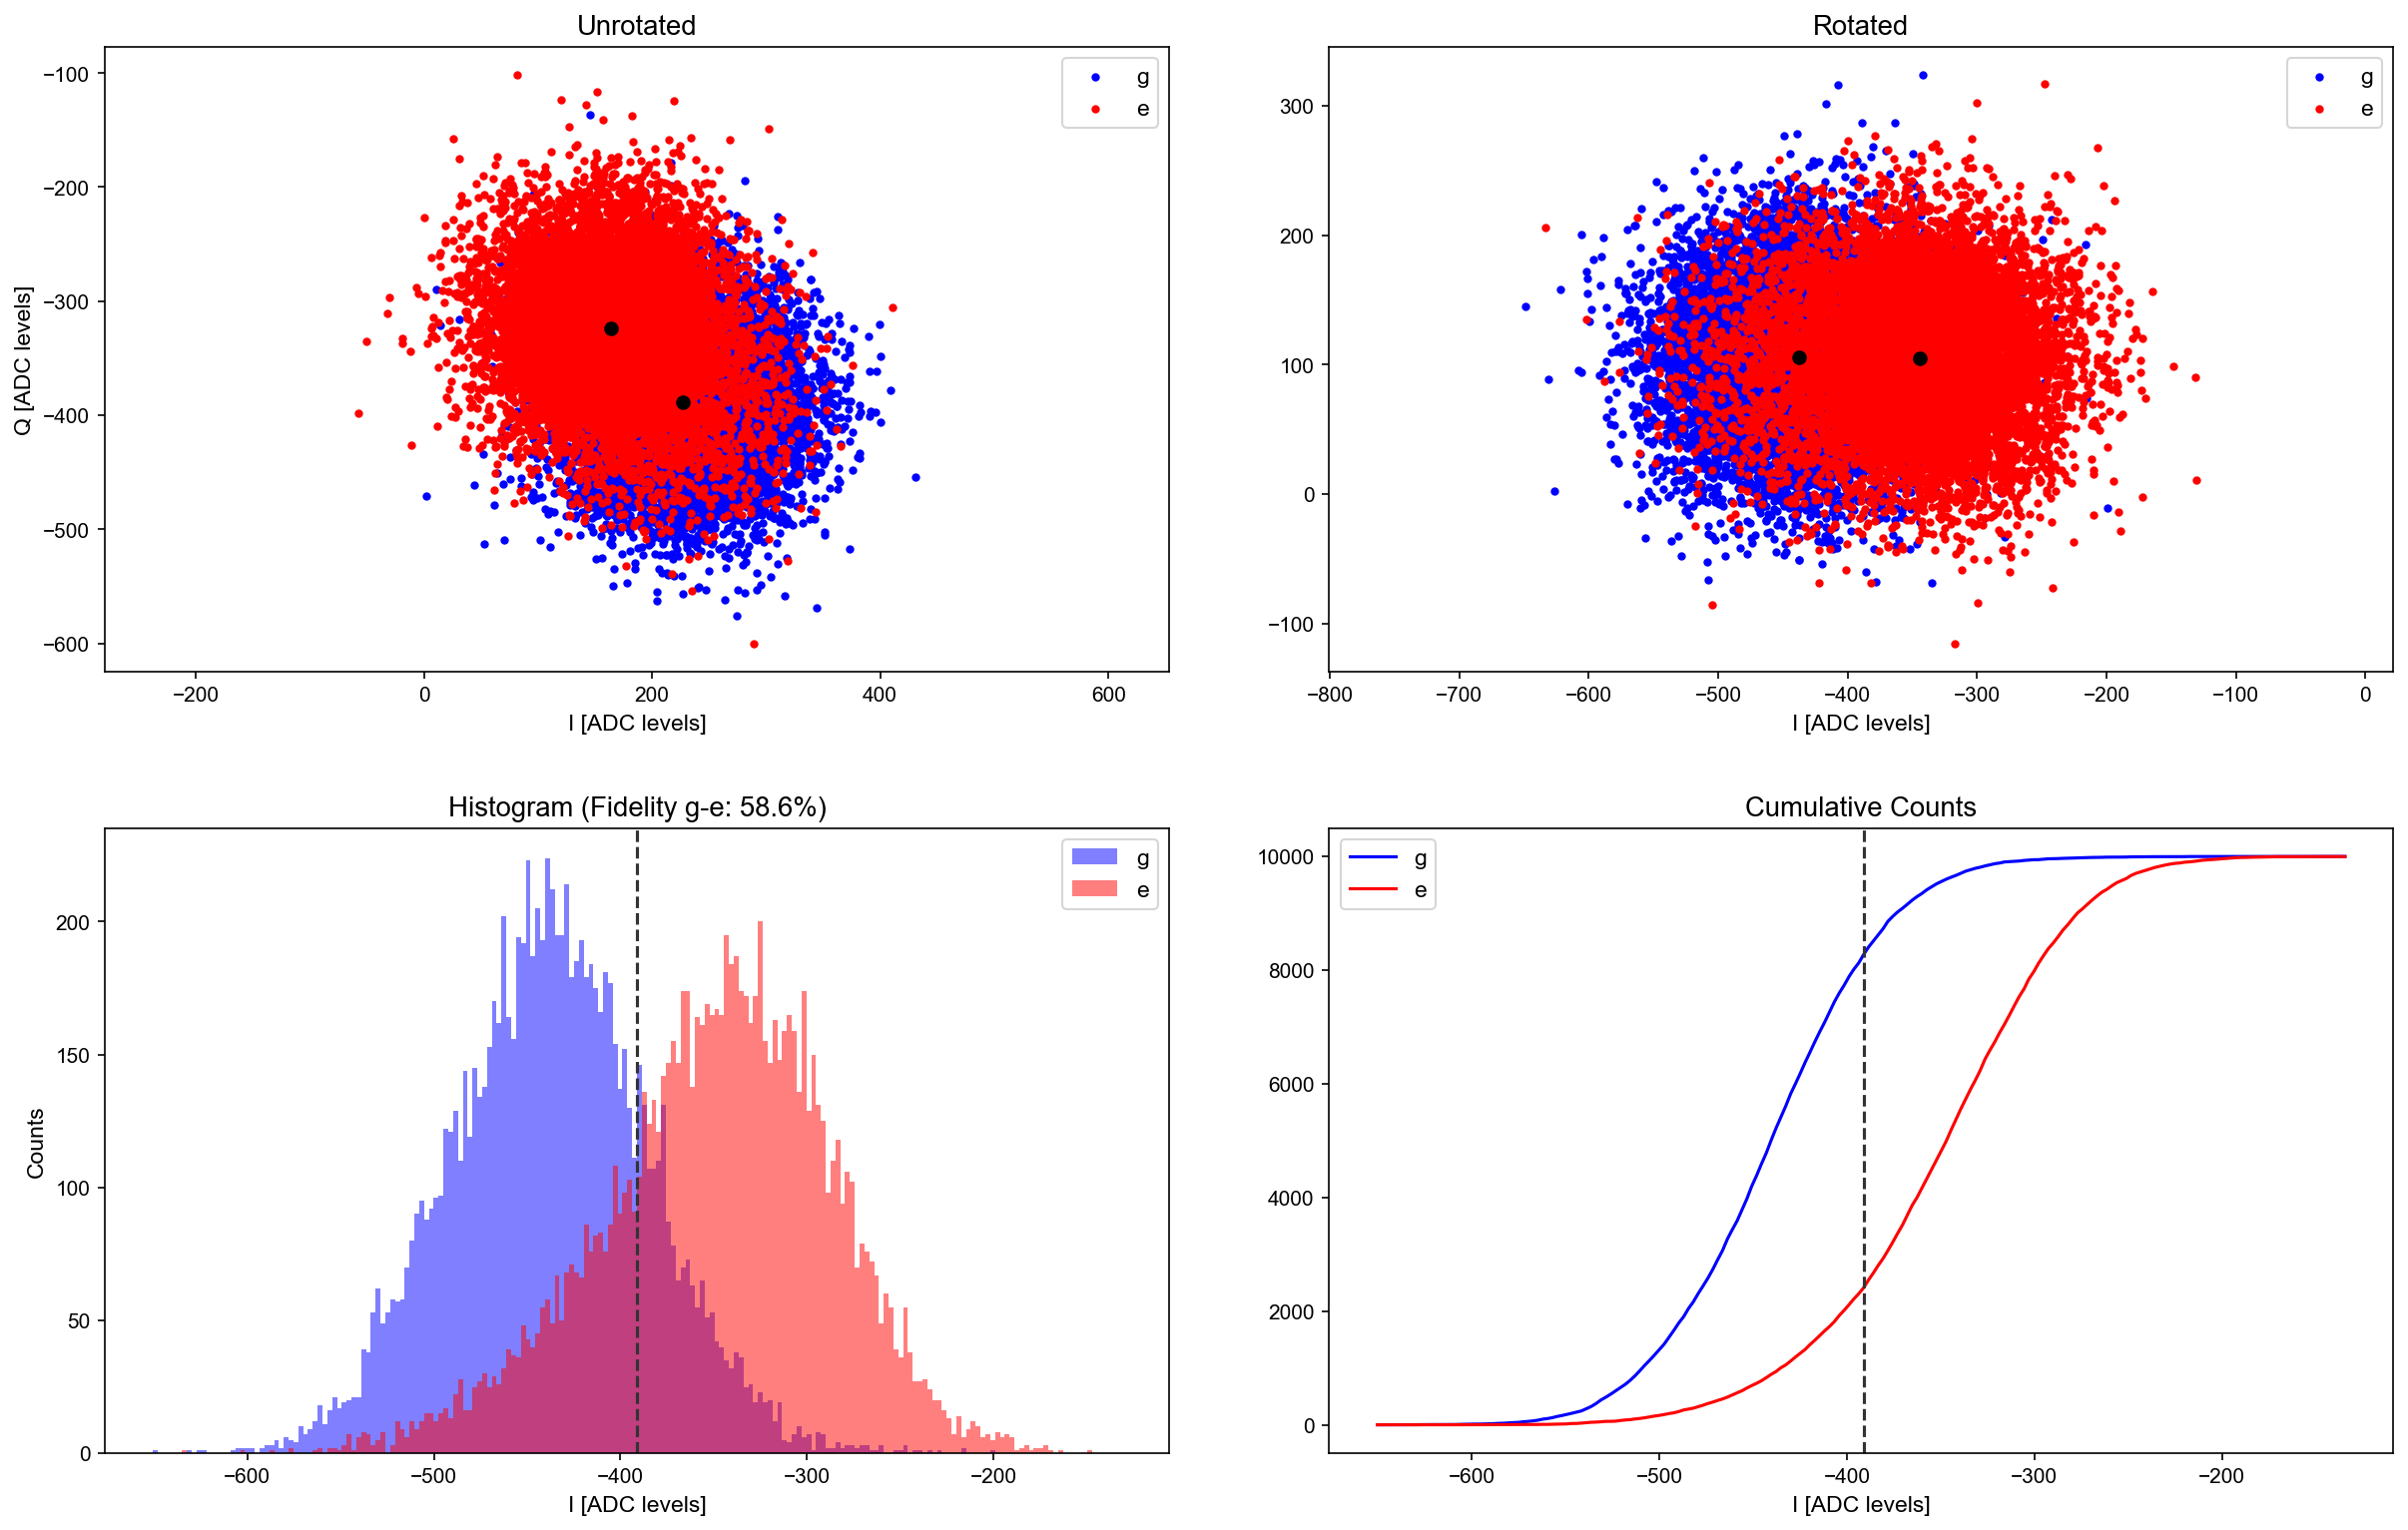

thresholds [0, -391.10148570340516, 0, 798.8710487113221]
angles [0, -133.7506557381558, 0, -123.56405072827634]


  0%|          | 0/9 [00:00<?, ?it/s]

In [31]:
tomoExpt = meas.EgGfStateTomographyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGf_state_tomo_{tomo_qubits[0]}{tomo_qubits[1]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    reps=5000, # reps per measurement basis
    singleshot_reps=10000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
    calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
)

print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [32]:
tomo = tomoExpt
# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00062_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

data = tomo.data
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == meas_order)
assert np.all(np.array(tomo.calib_order) == calib_order)

n_tomo_raw = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

np.set_printoptions(suppress=True)

print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(correct_readout_err(n_tomo_raw, n_calib))
print('Negative counts corrected tomo matrix will be')
print(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

n_tomo = fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib))

Tomography counts
[[1683 1538  883  896]
 [1672 1539  964  825]
 [ 683 2516  369 1432]
 [1349 1303 1157 1191]
 [ 890 1844  844 1422]
 [ 535 2128  494 1843]
 [1367 1338 1099 1196]
 [ 880 1784  823 1513]
 [ 523 2109  532 1836]]
Confusion matrix counts
[[5157 1198 2969  676]
 [1479 4948  827 2746]
 [3323  987 4434 1256]
 [1309 3096 1656 3939]]
Confusion matrix corrected tomo matrix will be
[[2795.86672 2320.53273 -430.97601  314.57657]
 [2480.85542 2599.47638   92.72957 -173.06137]
 [ -84.92004 5004.60928 -118.67491  198.98567]
 [1307.50626 1002.76527  865.56396 1824.16451]
 [  85.38146 2583.27329  788.13092 1543.21433]
 [-240.18235 2492.87486 -344.86944 3092.17693]
 [1497.27885 1068.76884  586.78266 1847.16965]
 [ 238.69773 2075.144    488.43926 2197.71902]
 [-372.26881 2476.0687  -150.66598 3046.86609]]
Negative counts corrected tomo matrix will be
[[2652. 2177.    0.  171.]
 [2423. 2542.   35.    0.]
 [   0. 4903.    0.   97.]
 [1308. 1003.  866. 1824.]
 [  85. 2583.  788. 1543.]
 [   

### Qram experiment

In [206]:
tomo_qubits = [2, 3] # which qubit/resonators to do tomo on

In [44]:
n_tomo_raw_rounds = []

n_calib_rounds = []
n_tomo_rounds = []

In [45]:
save_data = False

TOMO QUBITS [2, 3]


  0%|          | 0/1 [00:00<?, ?it/s]

time step size [cycles]: -9223372036854775808
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (2)


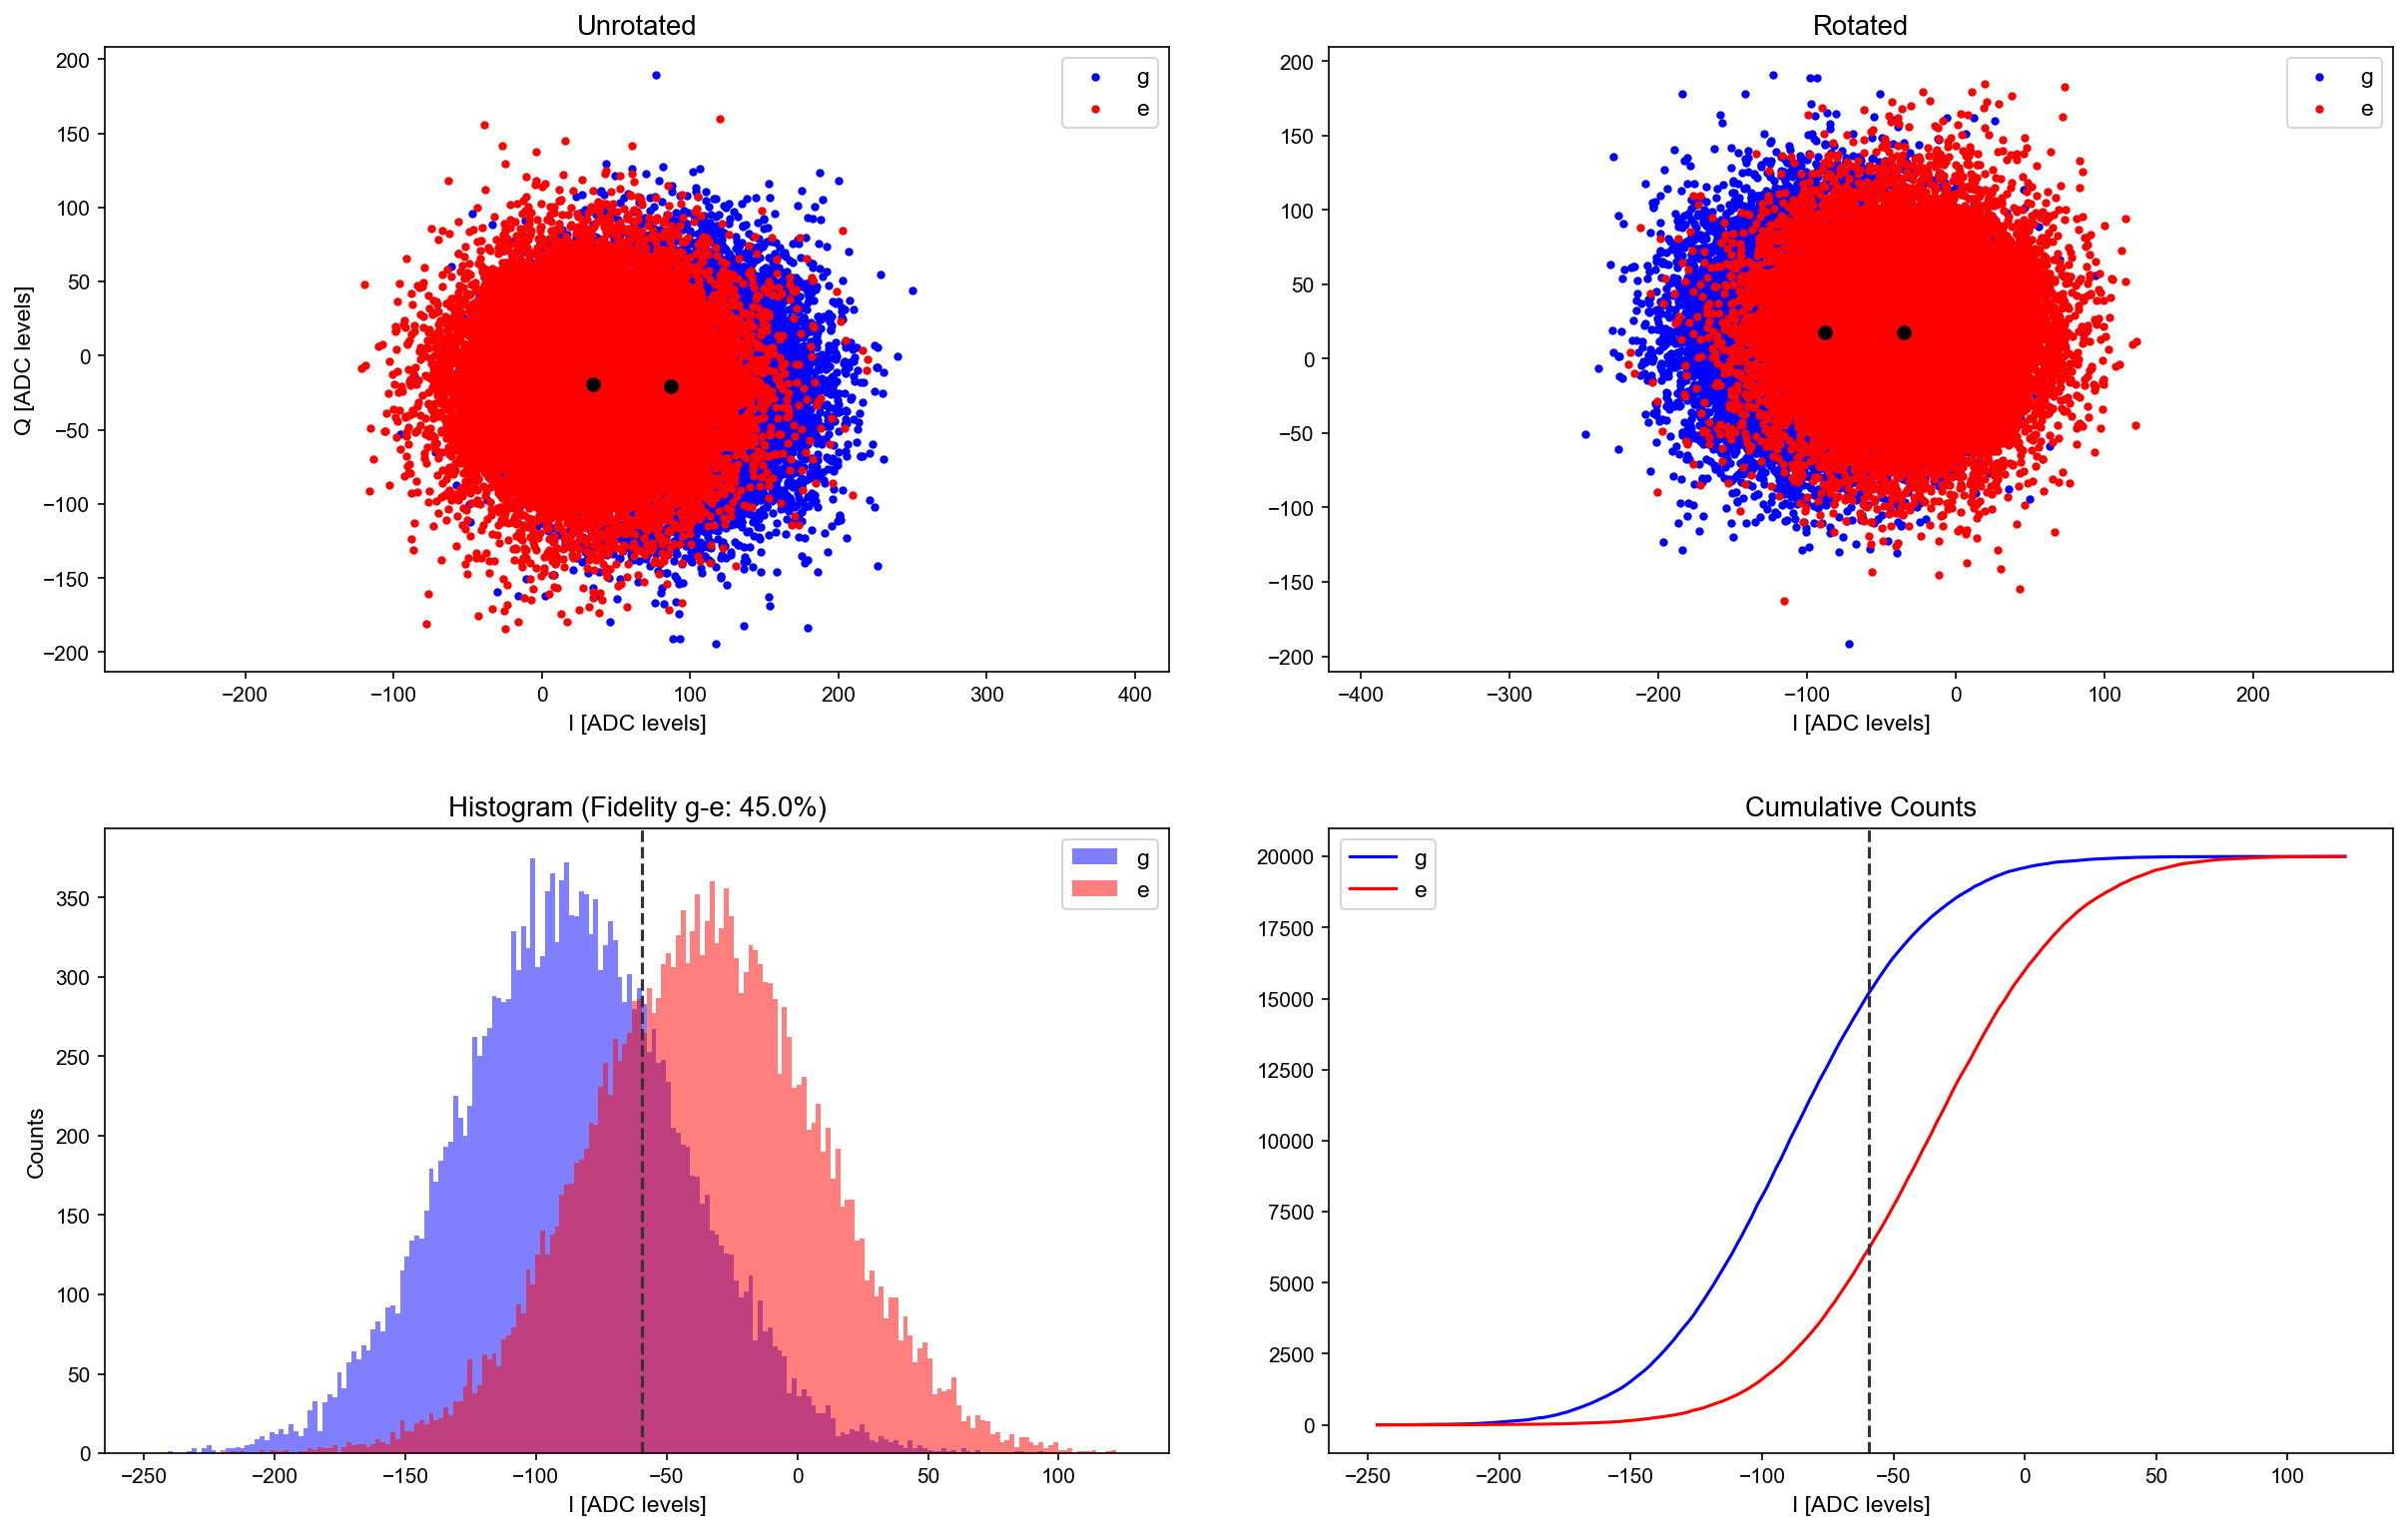

ge fidelity (%): 44.9611240281007 	 angle (deg): -178.4586353786394 	 threshold ge: -59.495669569936695
Qubit  (3)


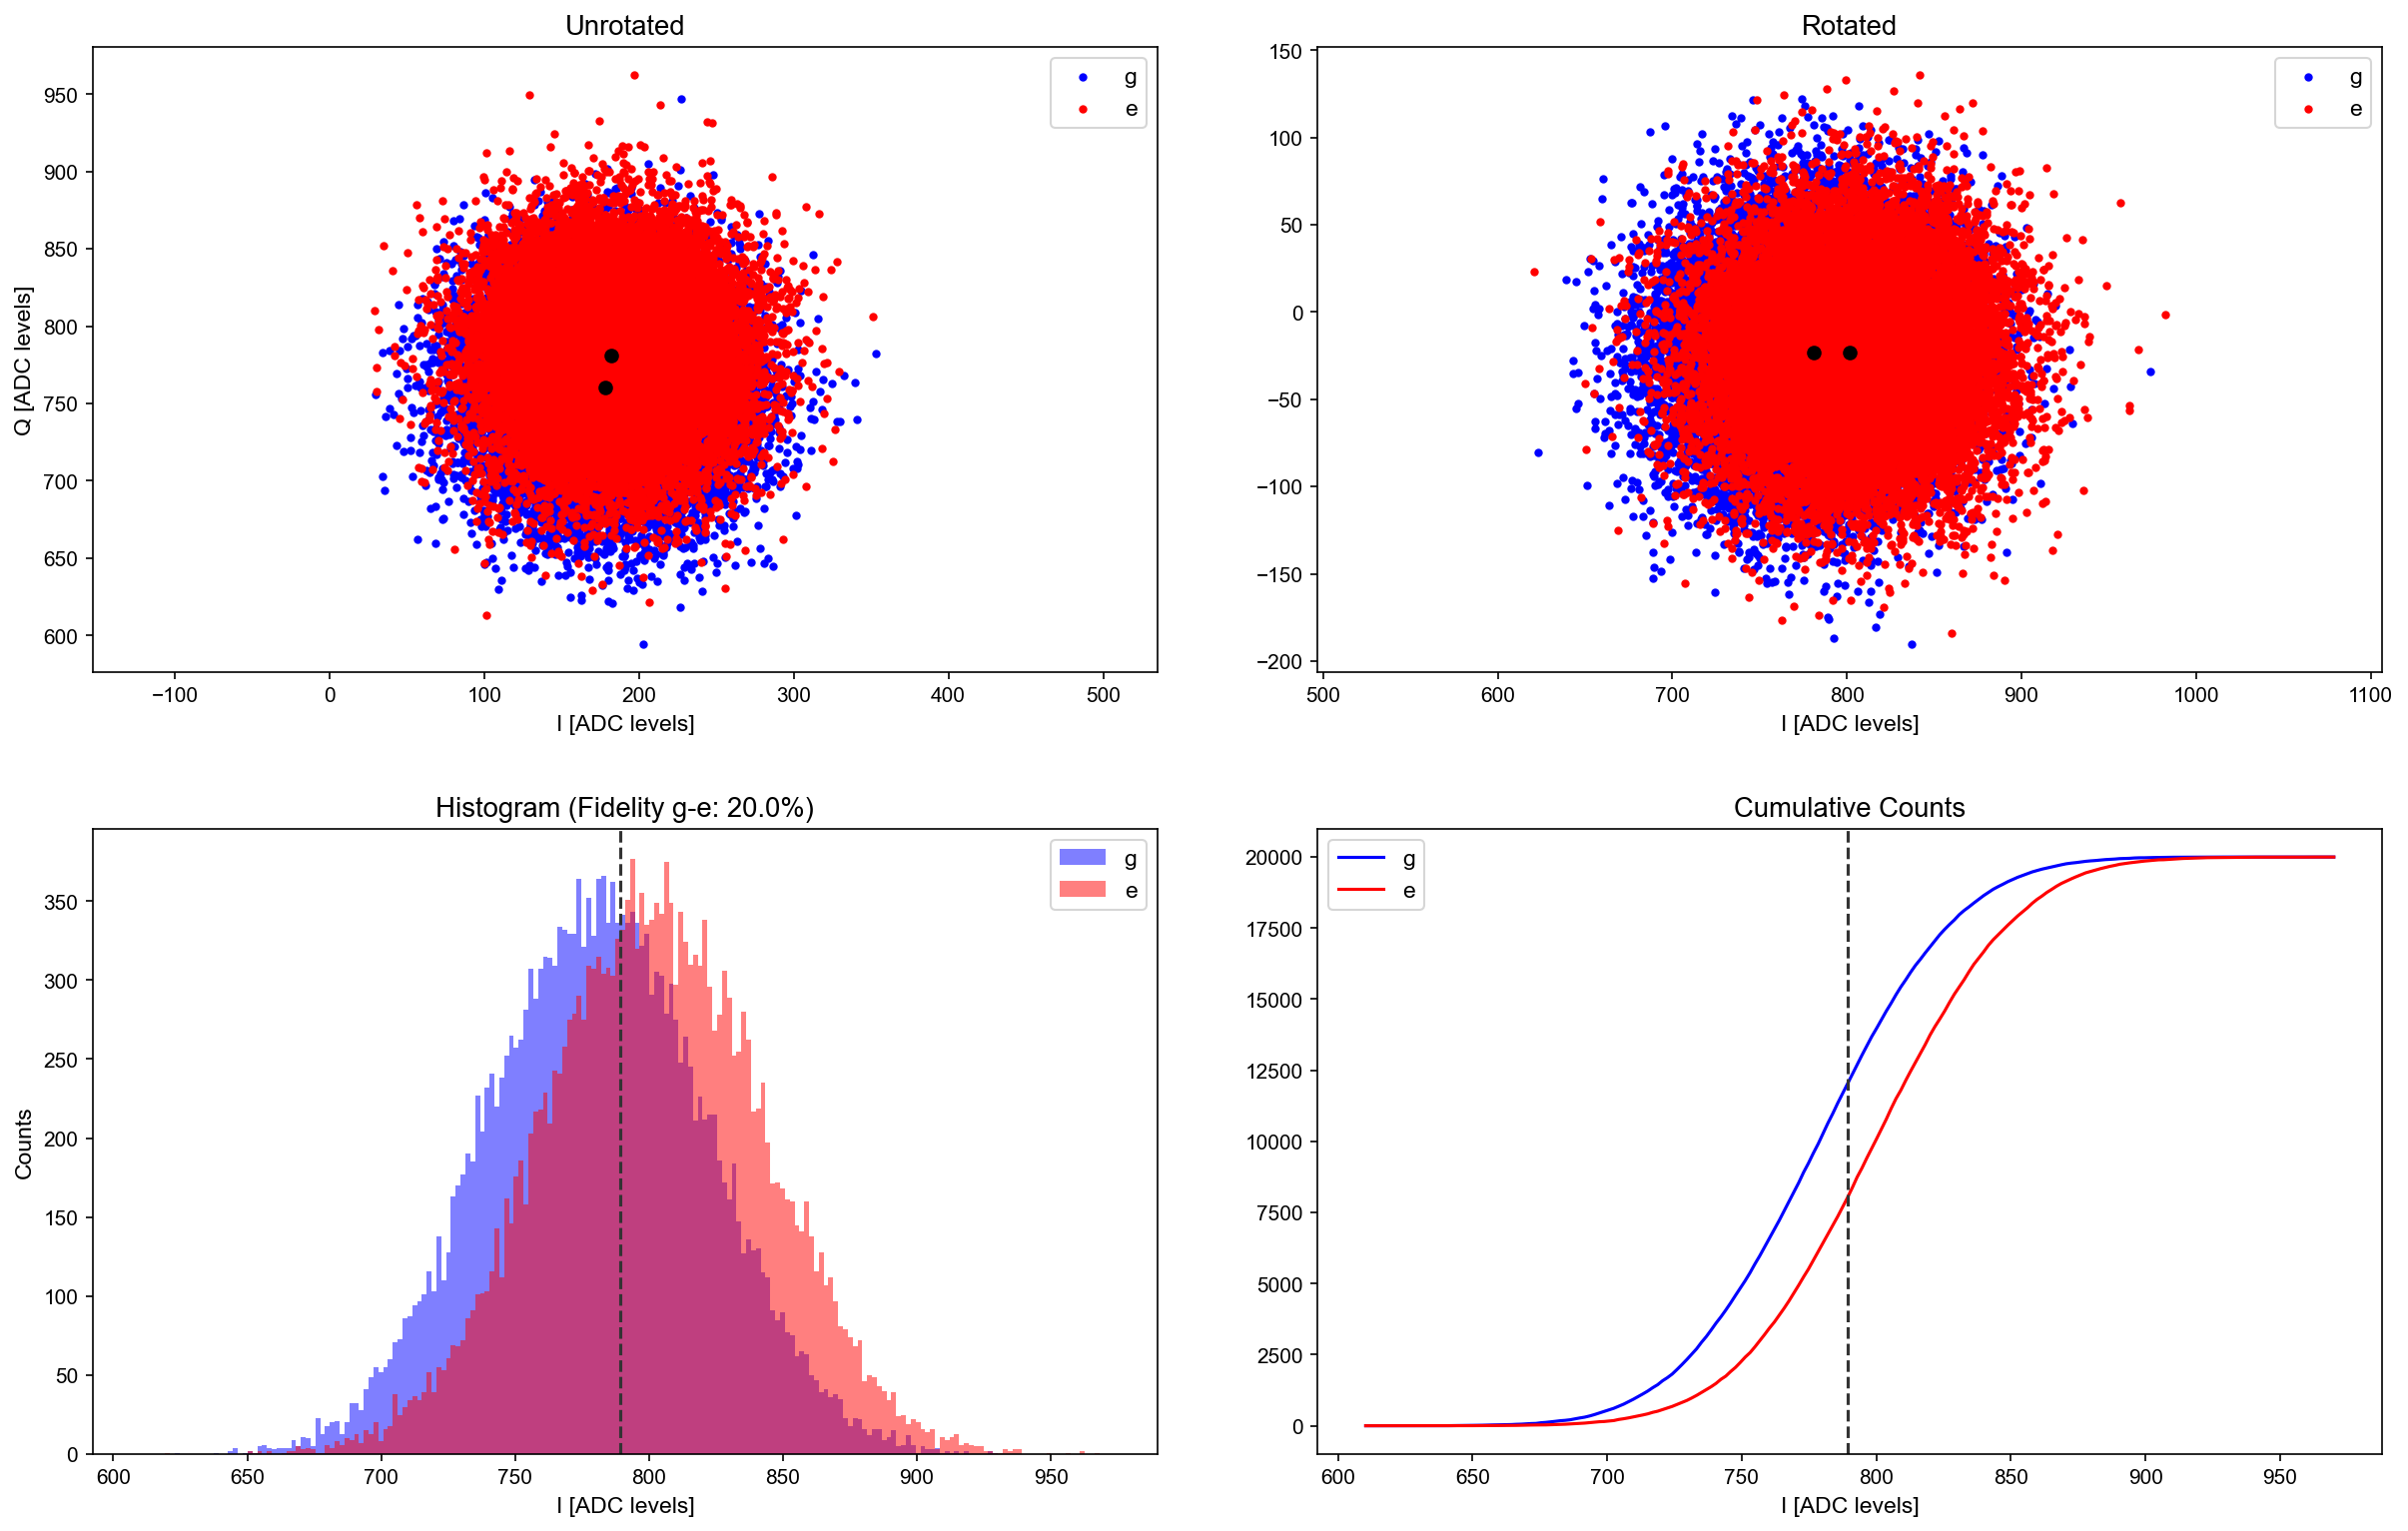

ge fidelity (%): 20.021001050052504 	 angle (deg): -78.5158610199525 	 threshold ge: 789.2711912390248


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (0)


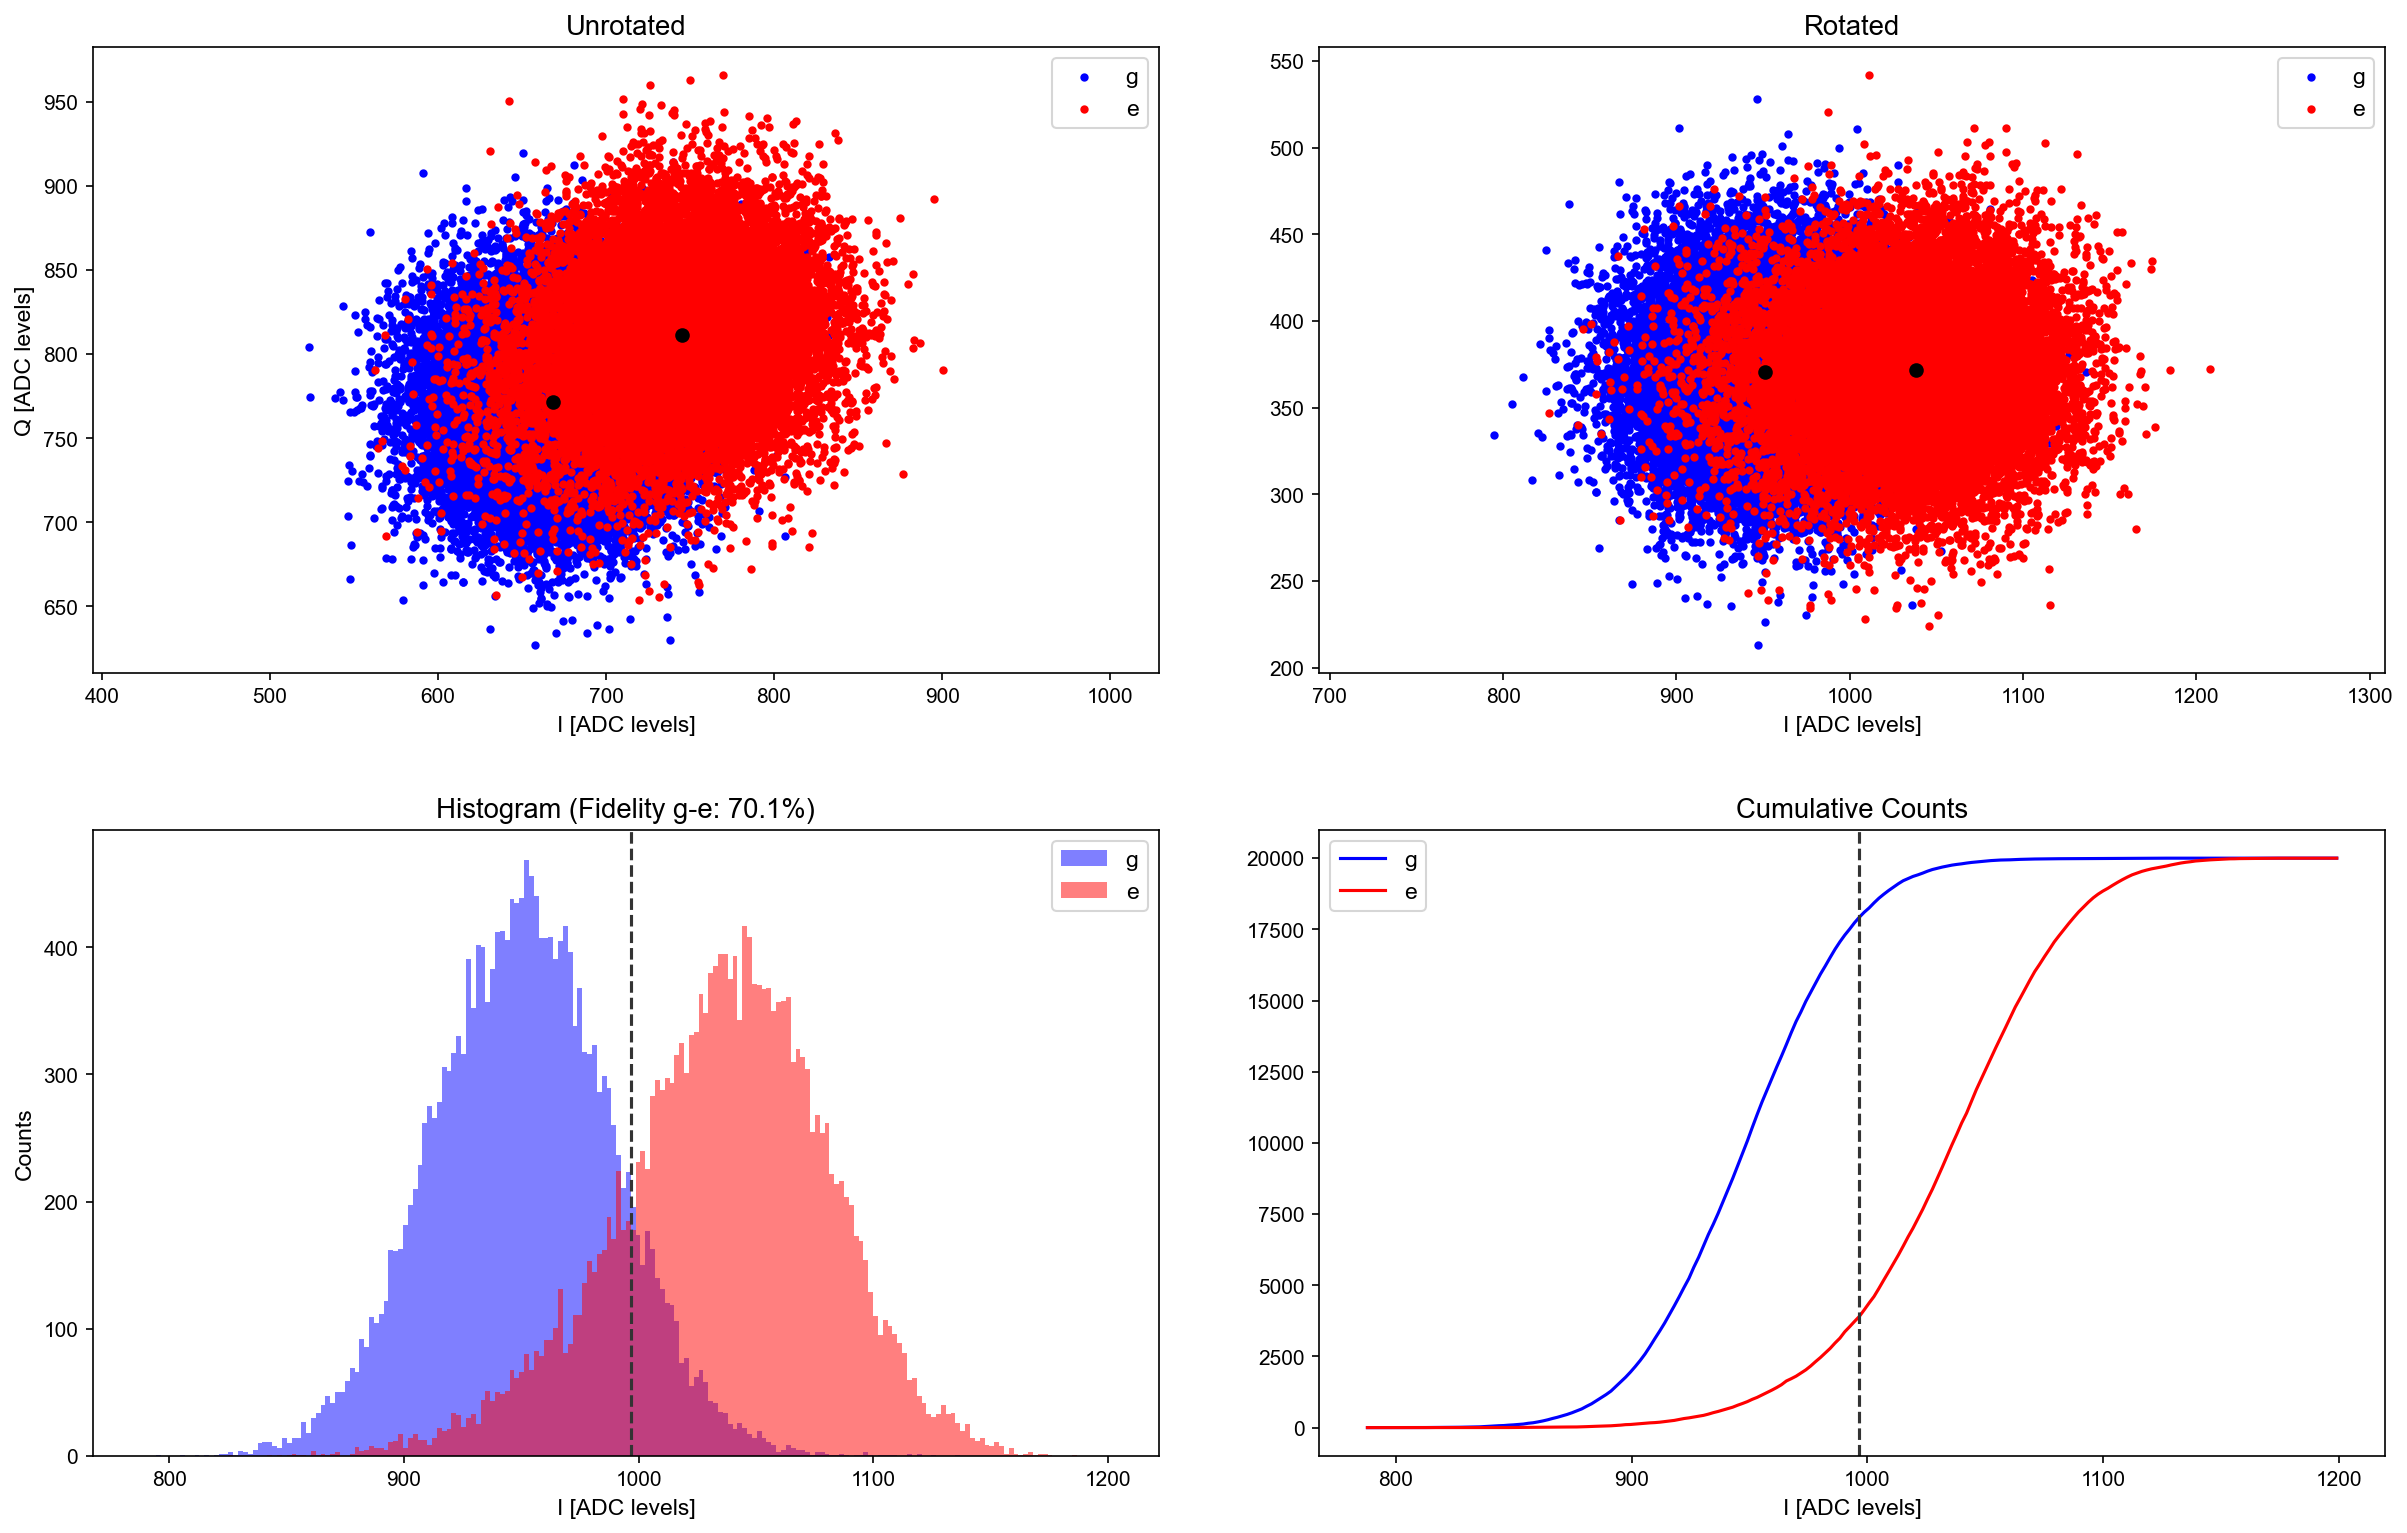

ge fidelity (%): 70.10675266881672 	 angle (deg): -27.775890394005774 	 threshold ge: 996.6932673180343
Qubit  (1)


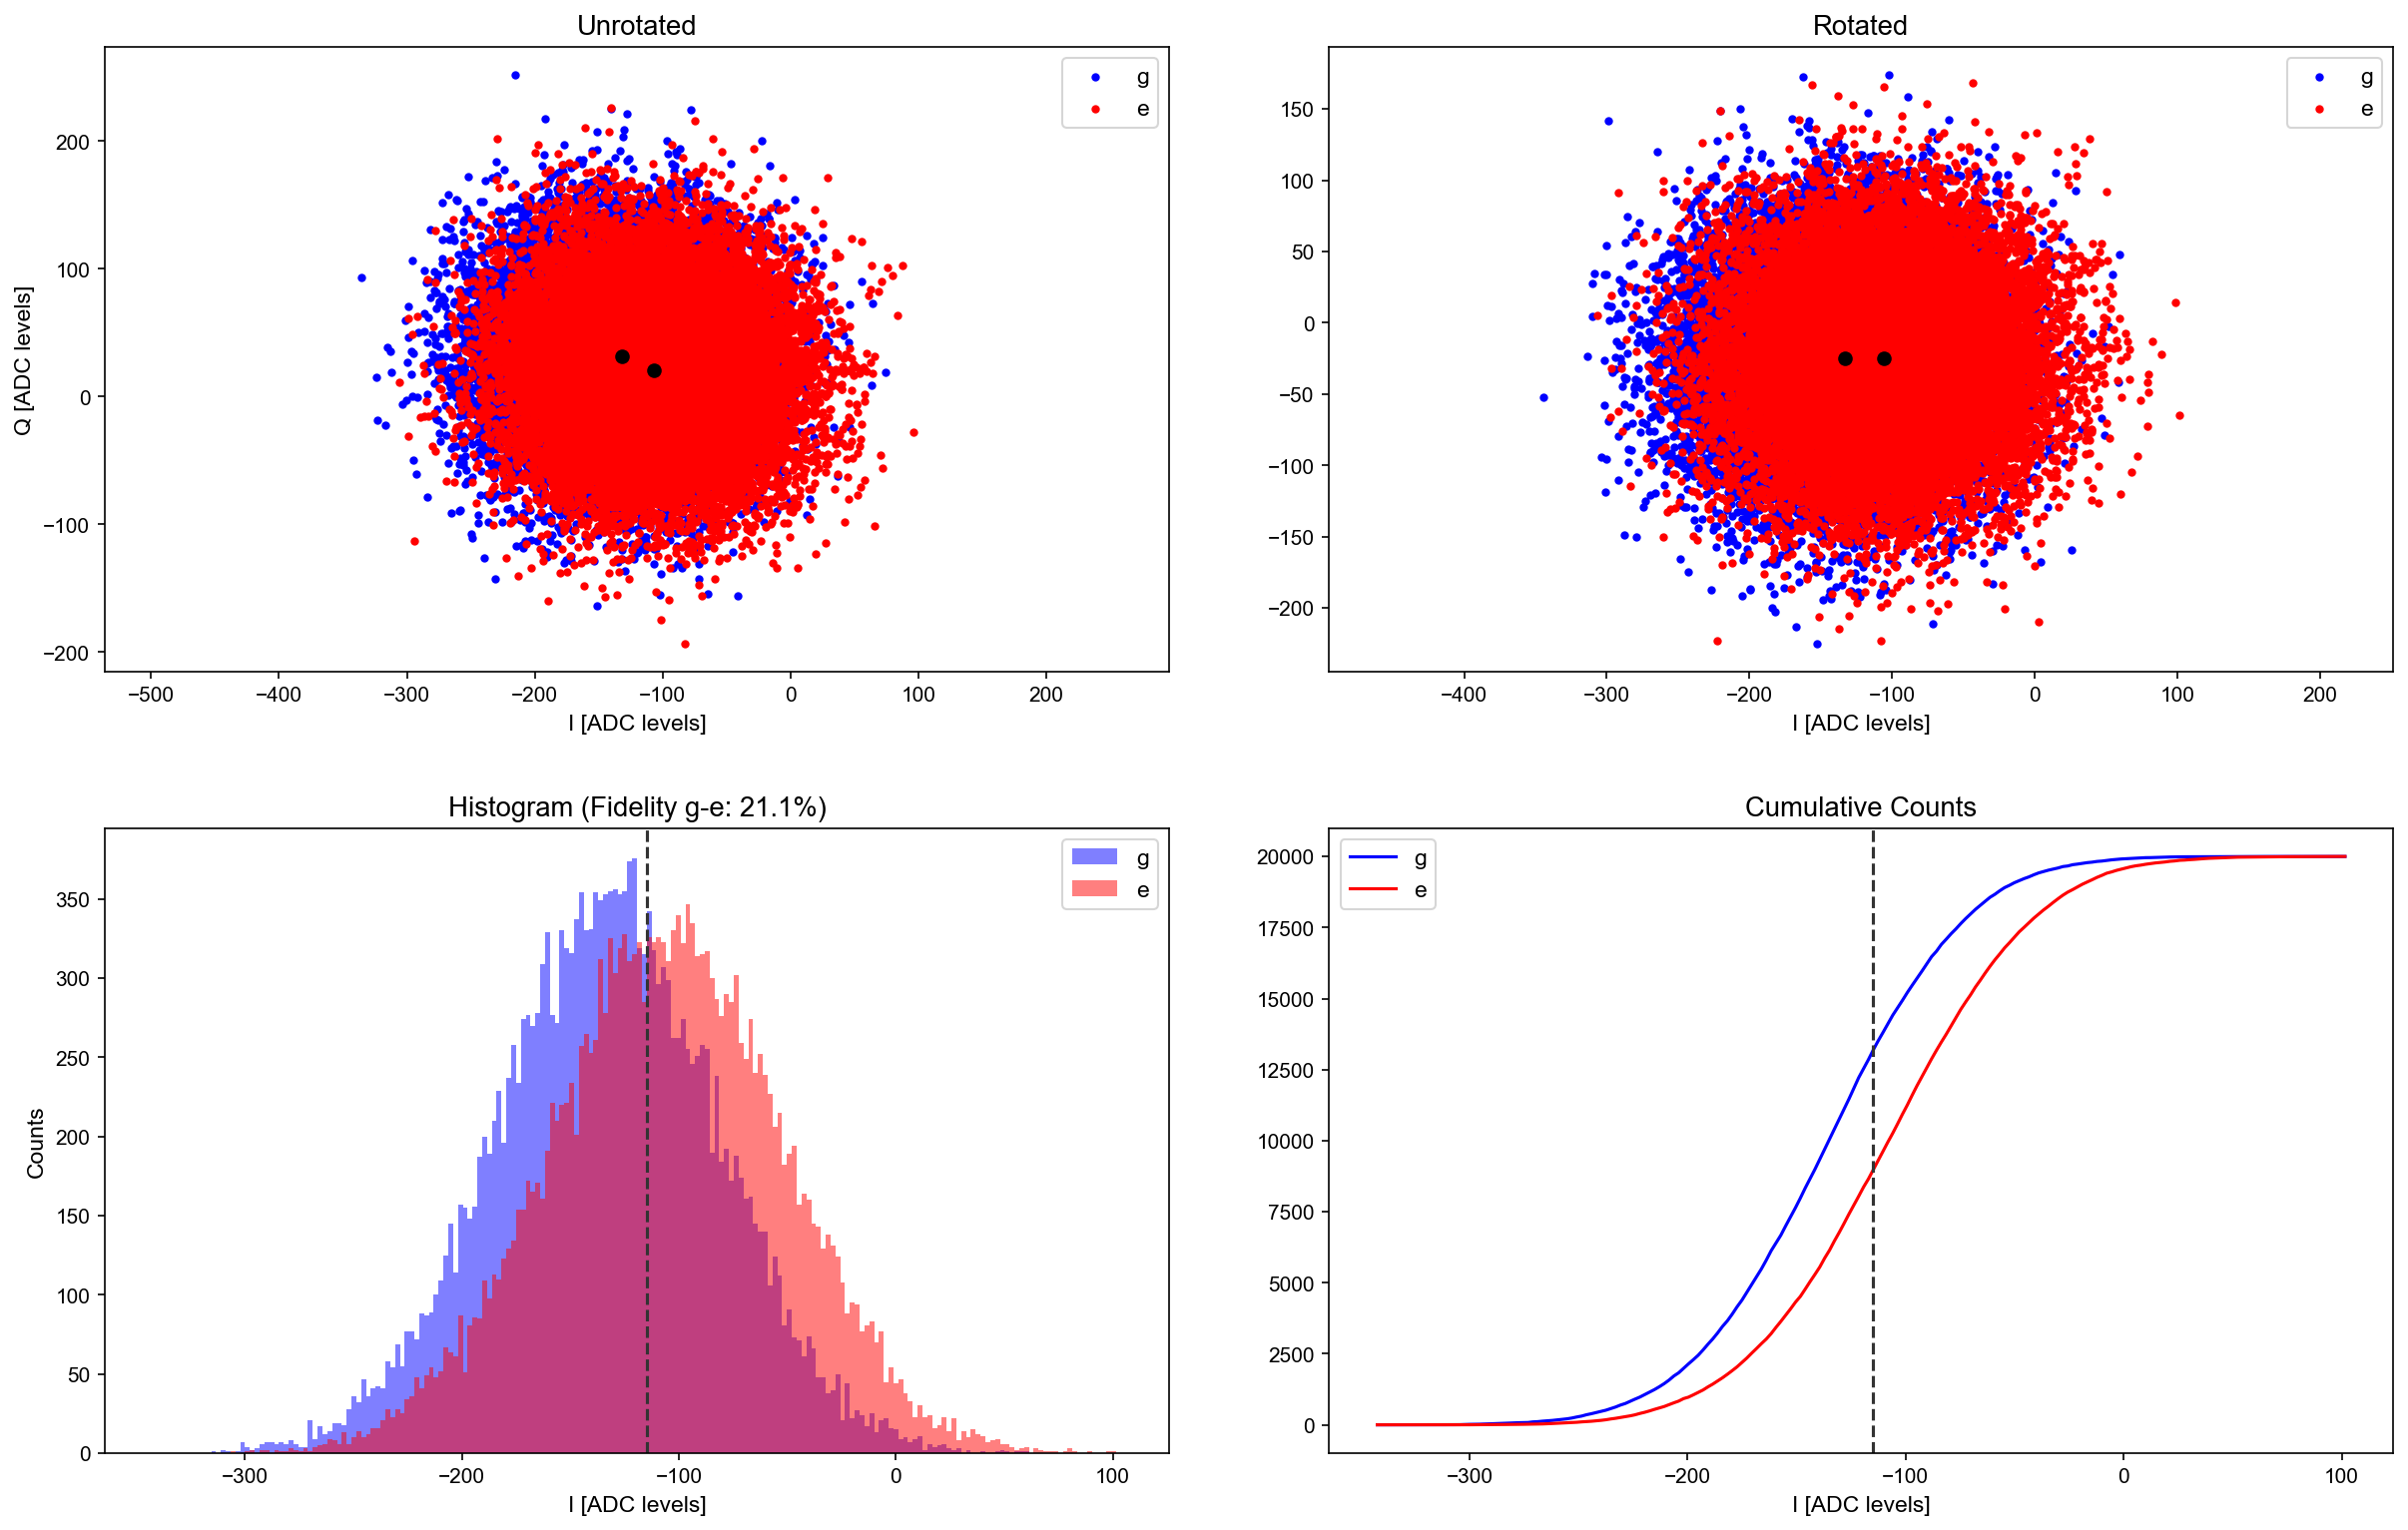

ge fidelity (%): 21.075526888172206 	 angle (deg): 24.097785640725597 	 threshold ge: -114.83719594519314
thresholds=[996.6932673180343, -114.83719594519314, -59.495669569936695, 789.2711912390248]
angles=[-27.775890394005774, 24.097785640725597, -178.4586353786394, -78.5158610199525]
ge_avgs=[[668.4352674461163, 771.1962, 742.9229674867833, 811.253770597804], [-132.08370707604715, 31.577629605530703, -107.0146673851159, 20.28405296868646], [86.77069867832451, -20.802203538023587, 35.057494570963804, -19.256005835705572], [177.79309290361934, 760.2748069743798, 182.48454355429038, 780.821625762505]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Total protocol time (us): 1.252
Total protocol time (us): 1.252
Total protocol time (us): 1.252
Total protocol time (us): 1.252
Total protocol time (us): 1.252
Total protocol time (us): 1.252
Total protocol time (us): 1.252
Total protocol time (us): 1.252
Total protocol time (us): 1.252


100%|██████████| 1/1 [01:48<00:00, 108.33s/it]


In [214]:
qramExpts = []
nrepeat = 1
print('TOMO QUBITS', tomo_qubits)

for i in tqdm(range(nrepeat)):
    qramExpt = meas.QramProtocolExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )

    # span = 2.161196963262976 # total time [us]
    # span = 1.1659462011134218 # total time [us]
    span = np.inf
    npts = 1
    # span = 1.8 # total time [us]
    # npts = 120
    # span = 0.8 # total time [us]
    # npts = 10
    print('time step size [cycles]:', soc.us2cycles(span/npts))

    qramExpt.cfg.expt = dict(
        # start=0, # start protocol time [us],
        # step=span/npts, # time step [us], 
        # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

        start=span,
        step=0,
        expts=1, # number of different time experiments

        reps=7000, # number of reps per time step,
        # singleshot_reps=1, # reps per state for singleshot calibration
        singleshot_reps=20000, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        # thresholds=[48.765112894093534, 96.26256512031452, 332.5698328167488, 907.1402810621812],
        # ge_avgs=None, # (optional) don't rerun singleshot and instead use this
        # angles=[54.85719696454403, -4.061056979857183, 77.35730820785261, -80.28753842272687]
        tomo_2q=True, # True/False whether to do 2q state tomography on state at last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 2q state tomo
        calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
        post_select=True,
        init_state='|0+1>|0+1>',
    )

    # print(qramExpt.cfg)

    import Pyro4.util
    try:
        qramExpt.go(analyze=False, display=False, progress=nrepeat<2, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    # tomo = qramExpt
    # data = tomo.data
    # n_tomo_raw = np.array(data['counts_tomo'])
    # n_calib = np.array(data['counts_calib'])

    # n_tomo_raw_rounds.append(n_tomo_raw)
    # n_calib_rounds.append(n_calib)
    # n_tomo_rounds.append(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

    qramExpts.append(qramExpt)
    if save_data: qramExpt.save_data()

s:\Connie\experiments\qramLL_4QR2/data\data_230217/00013_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']


 C:\_Lib\python\slab\datamanagement.py: 245

Saved qram_protocol.png


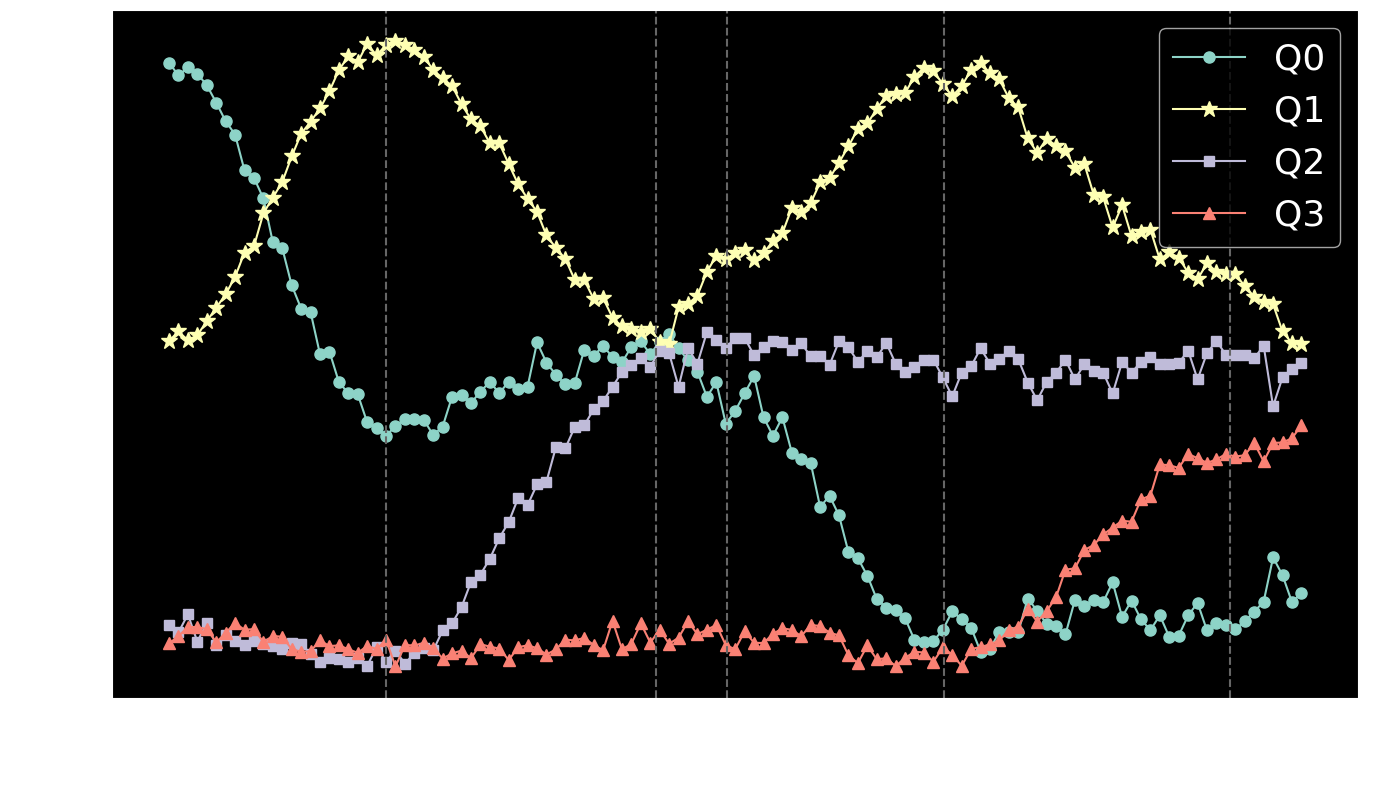

In [ ]:
data, attrs = prev_data(expt_path, 'data_230217/00013_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# data = None

style.use('default')
qramExpt.analyze(data=data)
qramExpt.display(data=data, err=False, saveplot=True)

In [225]:
qramExpt.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00013_qram_protocol.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_230217\\00013_qram_protocol.h5'

post processing average counts

In [223]:
postselect = True
postselect_state = 1 # select on Q1 being 0 or 1

In [224]:
n_tomo_raw_rounds = []
n_calib_rounds = []
n_tomo_rounds = []
for qramExpt in qramExpts:
    tomo = qramExpt
    data = tomo.data
    if postselect and qramExpt.cfg.expt.post_select:
        n_tomo_raw = np.array(data[f'counts_tomo_ps{postselect_state}'])
        print(f'Just getting states from post selection value of {postselect_state}')
    elif postselect and not qramExpt.cfg.expt.post_select:
        assert False, 'You are trying to post select but the experiment was not run with the post select flag=True!'
    elif qramExpt.cfg.expt.post_select: n_tomo_raw = np.array(data[f'counts_tomo_ps0'] + data[f'counts_tomo_ps1'])
    else: n_tomo_raw = np.array(data[f'counts_tomo'])
    n_calib = np.array(data['counts_calib'])

    # print('Tomography counts')
    # print(n_tomo_raw)
    # print('Confusion matrix counts')
    # print(n_calib)
    # print('Confusion matrix corrected tomo matrix will be')
    # print(correct_readout_err(n_tomo_raw, n_calib))
    # print('Negative counts corrected tomo matrix will be')
    # print(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

    n_tomo_raw_rounds.append(n_tomo_raw)
    n_calib_rounds.append(n_calib)
    n_tomo_rounds.append(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

pulse_dict = qramExpts[-1].pulse_dict

Just getting states from post selection value of 1


In [236]:
n_tomo_raw = np.average(n_tomo_raw_rounds, axis=0)
n_tomo_raw_std = np.std(n_tomo_raw_rounds, axis=0)
n_calib = np.average(n_calib_rounds, axis=0)
n_calib_std = np.std(n_calib_rounds, axis=0)
n_tomo_avg = np.average(n_tomo_rounds, axis=0)
n_tomo_std = np.std(n_tomo_rounds, axis=0)
n_tomo_corrected = fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib))
print(len(n_tomo_raw_rounds))

print('Average raw tomography counts')
print(n_tomo_raw)
print('Std raw tomography counts')
print(n_tomo_raw_std)
print('Average confusion matrix counts')
print(n_calib)
print('Std confusion matrix counts')
print(n_calib_std)
print('Average n_tomo')
print(n_tomo_avg)
print('Std n_tomo')
print(n_tomo_std)
print('Corrected average tomo with average calib counts, corrected for neg counts')
print(n_tomo_corrected)

# n_tomo = n_tomo_avg
n_tomo = n_tomo_corrected

1
Average raw tomography counts
[[1071. 1136.  775.  627.]
 [ 984. 1054.  752.  836.]
 [1000. 1132.  662.  755.]
 [ 980.  938.  919.  854.]
 [1001.  972.  895. 1025.]
 [ 960.  997.  900.  915.]
 [ 928.  908.  915.  921.]
 [ 961.  915.  955.  908.]
 [ 949.  958.  864. 1011.]]
Std raw tomography counts
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Average confusion matrix counts
[[8692. 6196. 2983. 2129.]
 [5702. 9200. 1978. 3120.]
 [3524. 2389. 8279. 5808.]
 [2319. 3480. 5609. 8592.]]
Std confusion matrix counts
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Average n_tomo
[[ 893. 1487. 1229.    0.]
 [1105. 1058.  541.  923.]
 [1036. 1384.  404.  725.]
 [1105.  744. 1228.  614.]
 [1371.  480.  526. 1516.]
 [ 950.  935. 1024.  863.]
 [1036.  647. 1039.  950.]
 [1075.  651. 1241.  772.]
 [1208.  568.  488. 1518.]]
Std n_tomo
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [

In [54]:
n_tomo = np.array( # |0>(|0+1>)
[[7000,    0,    0,    0.],
 [3792, 3073,  136,    0.],
 [3970, 2784,    0,  247.],
 [2472,    0, 4528,    0.],
 [1411, 1199, 2044, 2346.],
 [1533, 1196, 1949, 2322.],
 [2195,    0, 4805,    0.],
 [1624, 1141, 1970, 2265.],
 [1549, 1185, 2072, 2193.]]
)
 
n_tomo = np.array( # |1>(|0+1>)
[[ 971, 2621, 3408,    0.],
 [1845, 2063, 1577, 1515.],
 [1916, 1949, 1368, 1767.],
 [2170,  999, 2005, 1825.],
 [1757, 1430, 1434, 2378.],
 [1457, 1758, 1643, 2142.],
 [2217, 1055, 1985, 1743.],
 [1738, 1478, 1332, 2453.],
 [1841, 1476, 1305, 2378.]]
)

n_tomo = np.array( # (|0+1>)(|0+1>)
[[3569, 1651, 1780,    0.],
 [2896, 2730,  880,  495.],
 [2897, 2727,  773,  603.],
 [2200,  737, 3594,  470.],
 [1630, 1303, 2016, 2051.],
 [1626, 1360, 1906, 2108.],
 [2408,  460, 3146,  987.],
 [1430, 1641, 2026, 1904.],
 [1478, 1387, 1767, 2368.]]
)

# n_tomo = np.array( # (|0+i1>)(|0+1>)
# [[3163., 2173., 1664.,    0.],
#  [2438., 3299.,  806.,  456.],
#  [2627., 3226.,  722.,  425.],
#  [1857., 1092., 3028., 1023.],
#  [1242., 1632., 1695., 2431.],
#  [1469., 1365., 1518., 2647.],
#  [1980.,  885., 2896., 1239.],
#  [1300., 1627., 1468., 2605.],
#  [ 963., 1985., 1752., 2300.]])


## Run analysis

Get ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [210]:
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psi00 = qt.tensor(psiZ[0], psiZ[0])
psi01 = qt.tensor(psiZ[0], psiZ[1])
psi10 = qt.tensor(psiZ[1], psiZ[0])
psi11 = qt.tensor(psiZ[1], psiZ[1])

rho_ids = dict()
rho_ids.update({'|0>|0+1>':qt.ket2dm(psi00).unit()})
rho_ids.update({'|1>|0+1>':(qt.ket2dm(psi10) + qt.ket2dm(psi01)).unit()})
rho_ids.update({'|0+1>|0+1>':(qt.ket2dm(psi00 + psi10) + qt.ket2dm(psi00 + psi01)).unit()})
rho_ids.update({'|0+i1>|0+1>':(qt.ket2dm(psi00 + 1j*psi10) + qt.ket2dm(psi00 + 1j*psi01)).unit()})

rho_id = rho_ids['|0+1>|0+1>'] # input the initial qram state

In [176]:
# rho_id = qt.ket2dm(psi00 + psi01 + 1j*psi10 + 1j*psi11).unit()
rho_id = qt.ket2dm(psi10 - psi01).unit()
# rho_id = qt.ket2dm(psi01 + psi11).unit()
# rho_id = qt.ket2dm(psi11).unit()
# rho_id = (qt.ket2dm(psi00 + psi10) + qt.ket2dm(psi00 - psi10)).unit()
print(rho_id)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.   0.   0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [ 0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]


In [937]:
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))

rho_id = qt.Qobj(inpt=np.array( # |0>|0+1> input, forward simulation smaller amps, averaged pi pulses, q2/q3
[[ 9.94334173e-01+0.00000000e+00j,  2.95488839e-03+2.64962413e-02j,
  -3.99682679e-02+3.78054489e-03j, -6.56741155e-04-6.61718964e-04j],
 [ 2.95488839e-03-2.64962413e-02j,  2.86287490e-03+0.00000000e+00j,
   1.53294276e-03+7.60564506e-04j,  4.58698399e-05+2.23372708e-05j],
 [-3.99682679e-02-3.78054489e-03j,  1.53294276e-03-7.60564506e-04j,
   2.80004978e-03+0.00000000e+00j,  7.02786998e-05+4.37663736e-05j],
 [-6.56741155e-04+6.61718964e-04j,  4.58698399e-05-2.23372708e-05j,
   7.02786998e-05-4.37663736e-05j,  2.90278805e-06+0.00000000e+00j]]),
                 dims=id2q.dims, shape=id2q.shape)

rho_id = qt.Qobj(inpt=np.array( # |1>|0+1> input, forward simulation smaller amps, averaged pi pulses, q2/q3
[[ 3.38438199e-02+0.j,          2.90016564e-02+0.0076546j,
   2.27304815e-02+0.02020951j,  3.25013850e-04-0.00128582j],
 [ 2.90016564e-02-0.0076546j,   4.37932330e-01+0.j,
   1.61108049e-02+0.06338435j,  3.46390289e-03-0.00225456j],
 [ 2.27304815e-02-0.02020951j,  1.61108049e-02-0.06338435j,
   5.27034025e-01+0.j,         -1.07877095e-02-0.02246233j],
 [ 3.25013850e-04+0.00128582j,  3.46390289e-03+0.00225456j,
  -1.07877095e-02+0.02246233j,  1.18982534e-03+0.j        ]]),
                 dims=id2q.dims, shape=id2q.shape)

rho_id = qt.Qobj(inpt=np.array( # |0+1>|0+1> input, forward simulation smaller amps, averaged pi pulses, q2/q3
[[ 0.53234465+0.j,          0.19802137-0.19909149j,  0.08928398-0.15774758j,
  -0.00578382+0.00399767j],
 [ 0.19802137+0.19909149j,  0.23013877+0.j,          0.00366835+0.03578997j,
   0.00295272+0.00026102j],
 [ 0.08928398+0.15774758j,  0.00366835-0.03578997j,  0.23679742+0.j,
  -0.00993785-0.00788855j],
 [-0.00578382-0.00399767j,  0.00295272-0.00026102j, -0.00993785+0.00788855j,
   0.00071917+0.j        ]]),
                 dims=id2q.dims, shape=id2q.shape)

rho_id = qt.Qobj(inpt=np.array( # |0+i1>|0+1> input, forward simulation smaller amps, averaged pi pulses, q2/q3
[[ 5.34049918e-01+0.j,         -2.04750116e-01+0.0611259j,
  -8.59022996e-02+0.25596306j,  5.60009806e-03-0.00742929j],
 [-2.04750116e-01-0.0611259j,   1.96166943e-01+0.j,
  -3.44181418e-02-0.03603372j, -2.42826815e-03+0.00296604j],
 [-8.59022996e-02-0.25596306j, -3.44181418e-02+0.03603372j,
   2.69599718e-01+0.j,         -5.12968975e-03-0.0026015j ],
 [ 5.60009806e-03+0.00742929j, -2.42826815e-03-0.00296604j,
  -5.12968975e-03+0.0026015j,   1.83420731e-04+0.j        ]]),
                 dims=id2q.dims, shape=id2q.shape)

Generate test data

In [132]:
# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, evol_mats=evol_mats, noise=None)
n_calib = qt.qeye(4).full()
print(fix_neg_counts(n_tomo))

# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
# print(fix_neg_counts(n_tomo))

# n_tomo = [[2000, 2000, 2000, 2000.] ,
#  [2001, 1999, 3411,  589.] ,
#  [4005,    0, 3398,  602.] ,
#  [4010, 2179,    0, 1822.] ,
#  [4068, 2127,  802, 1019.] ,
#  [5895,  302,  806, 1016.] ,
#  [2008,  191, 1992, 3808.] ,
#  [ 649, 1552, 3754, 2043.] ,
#  [1523,  678,  233, 5564.]]

# n_tomo = [[   0,    0, 4000, 4000.],
#  [   0,    0, 6796, 1204.],
#  [   0,    0, 1179, 6821.],
#  [2004, 1167, 1996, 2833.],
#  [2048, 1126,  180, 4646.],
#  [ 127, 3046, 3258, 1568.],
#  [2005, 1167, 1995, 2833.],
#  [2048, 1127,  180, 4646.],
#  [ 127, 3046, 3258, 1568.],]

# n_tomo= [[2000, 2000., 2000., 2000.],
#  [2001, 1999., 2000., 2000.],
#  [4005,    0., 4000.,    0.],
#  [4010, 4002.,    0.,    0.],
#  [4012, 4005.,    0.,    0.],
#  [8021,    0.,    0.,    0.],
#  [2008, 2002., 1992., 1998.],
#  [2008, 2005., 1996., 1991.],
#  [4015,    0., 3987.,    0.],]


# n_tomo = np.array(
#     [[4978, 5022,    0,    0.],
#      [4807, 5193,    0,    0.],
#      [5002, 4998,    0,    0.],
#      [3880, 4899, 1221,    0.],
#      [4802, 4279,  919,    0.],
#      [5028, 4187,  727,   57.],
#      [4068, 5093,  839,    0.],
#      [4688, 4689,  622,    0.],
#      [4927, 4741,  332,    0.]]
# )


Generating with evol mats
[[   0. 4000.    0. 4000.]
 [2002. 1998. 1919. 2081.]
 [2001. 1999. 1918. 2082.]
 [   0. 6527.    0. 1475.]
 [3265. 3263.  708.  767.]
 [3264. 3264.  707.  768.]
 [   0. 7077.    0.  926.]
 [3540. 3537.  444.  482.]
 [3539. 3538.  444.  482.]]


##### Run MLE without ZZ correction

Convergence: True
Fidelity (no ZZ correction): 0.5727245666078378
Purity (no ZZ correction): 0.45730020366822133
[[ 0.246+0.j     0.048+0.016j -0.015-0.001j  0.006+0.005j]
 [ 0.048-0.016j  0.398+0.j     0.23 -0.01j   0.011+0.033j]
 [-0.015+0.001j  0.23 +0.01j   0.349+0.j    -0.023+0.024j]
 [ 0.006-0.005j  0.011-0.033j -0.023-0.024j  0.007+0.j   ]]


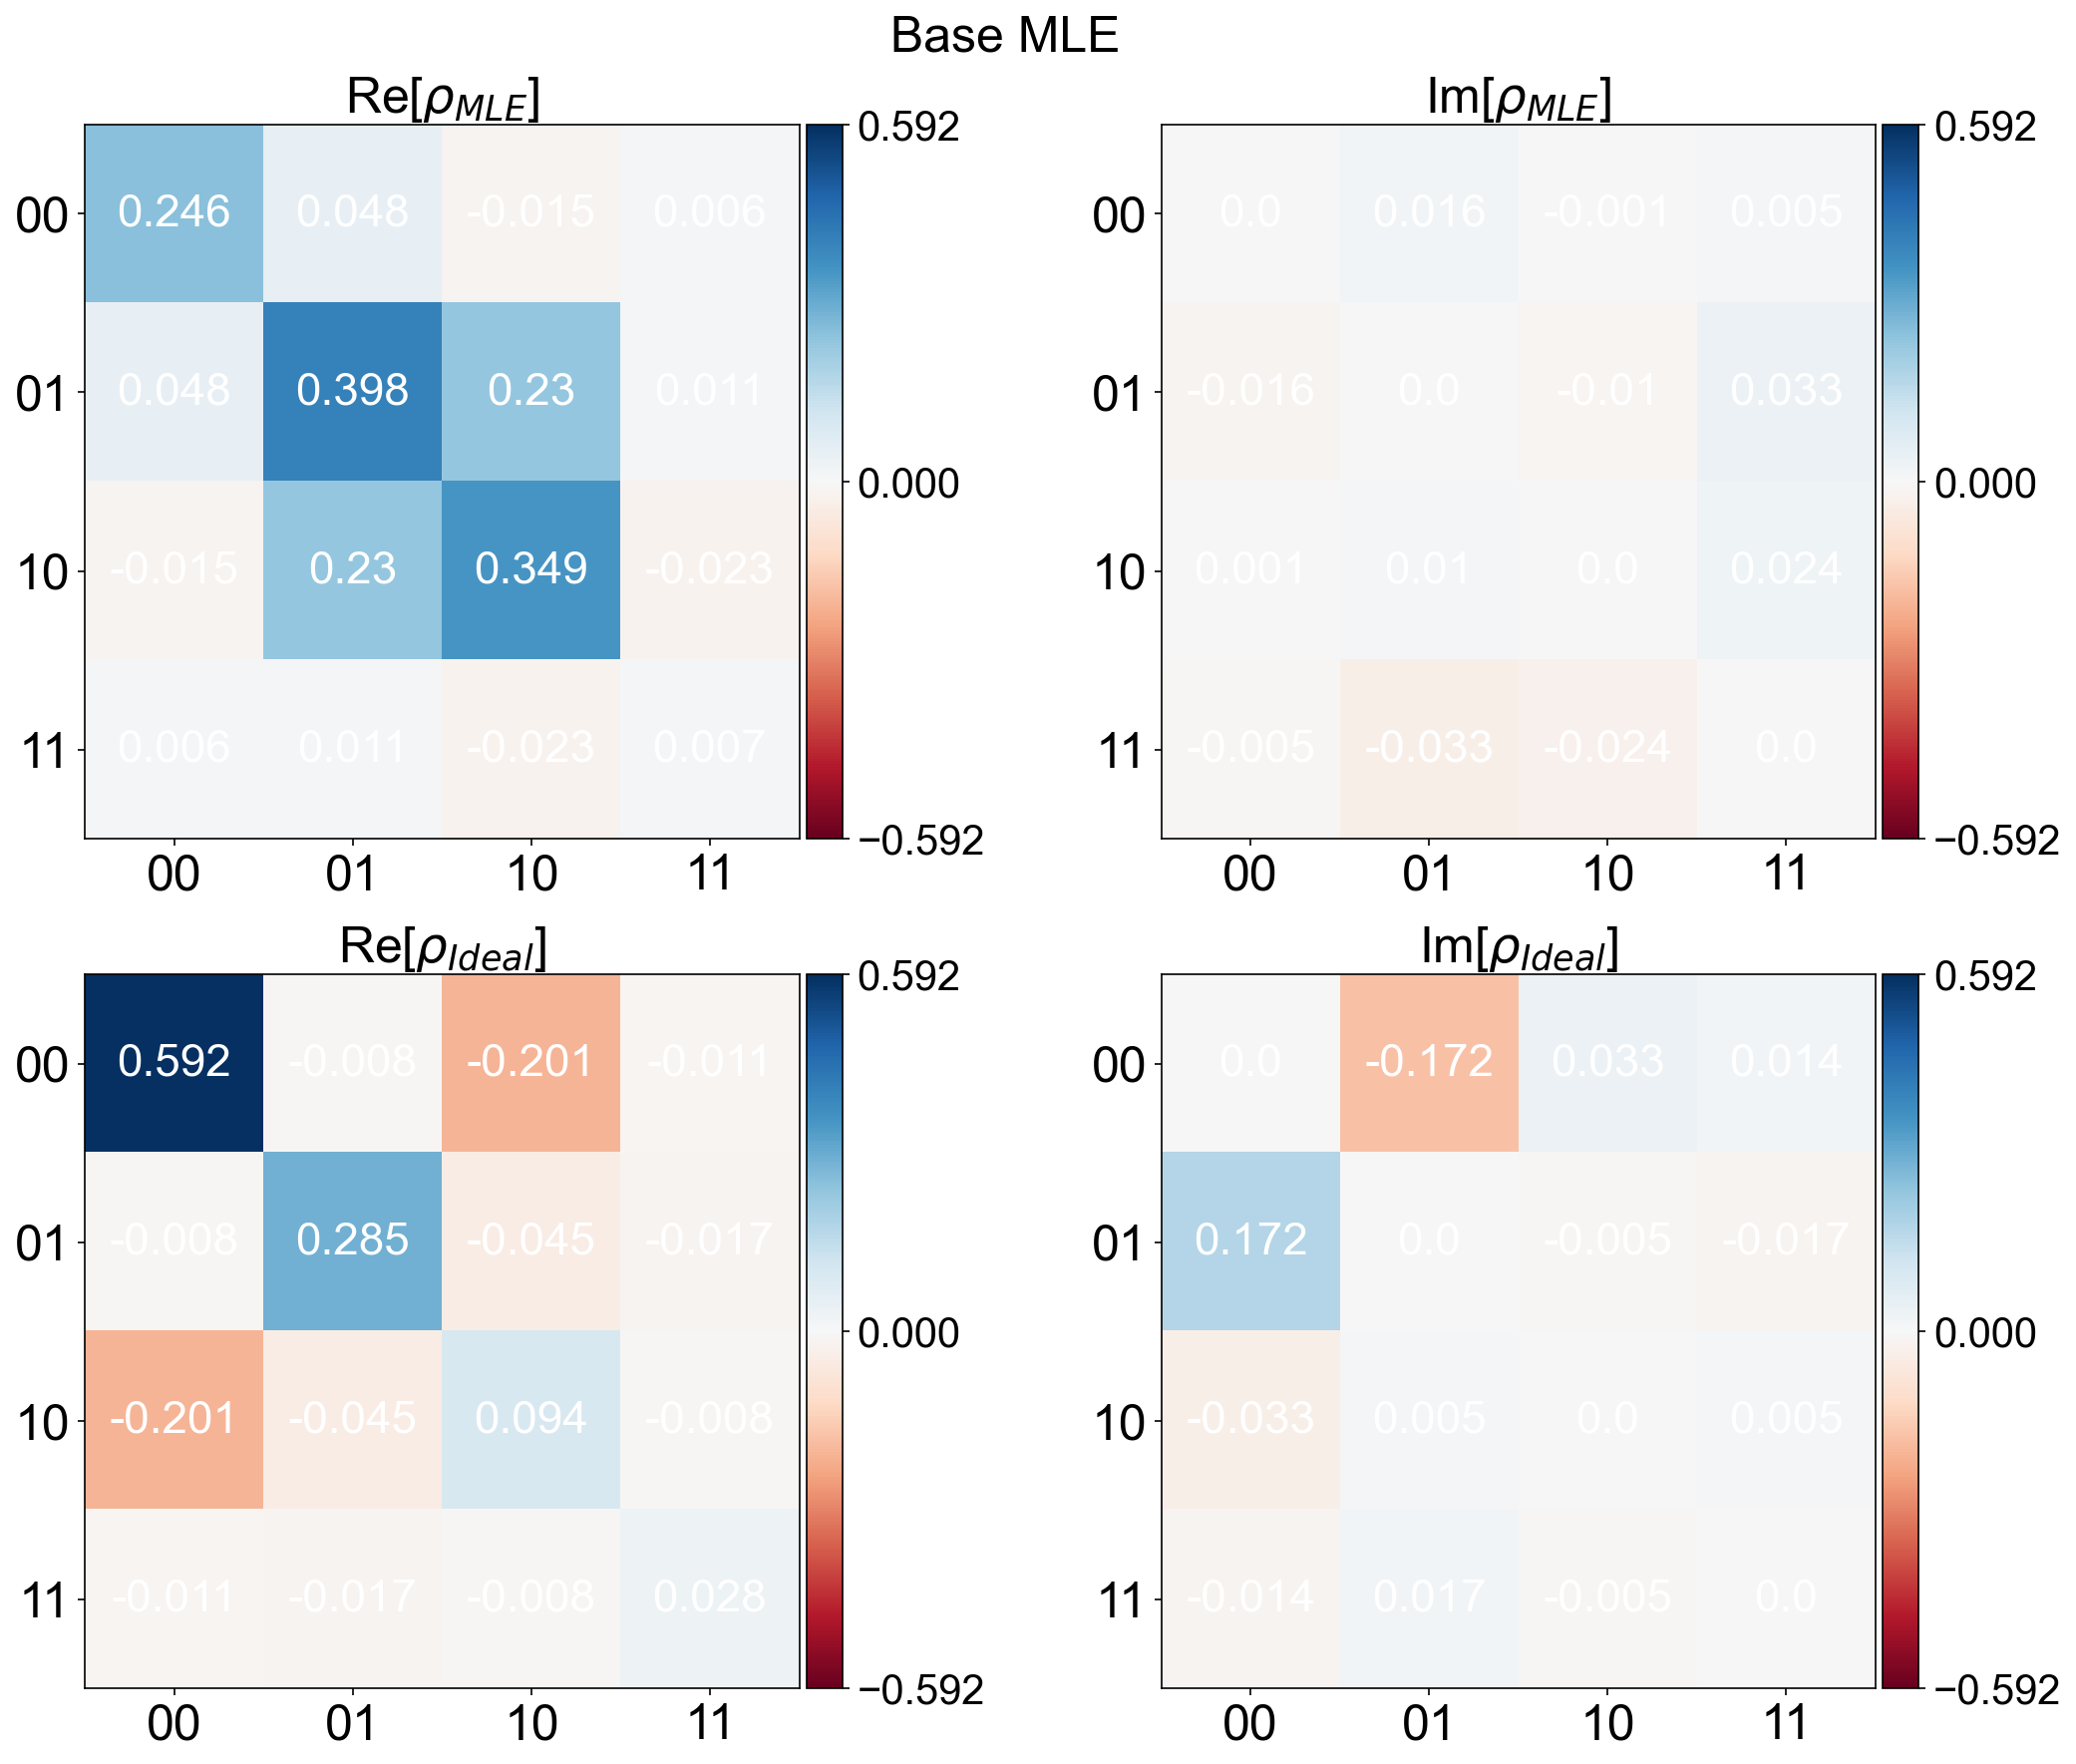

In [237]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE_base = run_MLE(n=n_tomo, rho_id=rho_id, ZZ_correction=False, method='L-BFGS-B')
# rho_MLE_base = run_MLE(n=fix_neg_counts(correct_readout_err(n_tomo, n_calib)), rho_id=rho_id, ZZ_correction=False, method='L-BFGS-B')
# print(rho_MLE_base

fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
print(f'Fidelity (no ZZ correction): {fid_base}')
print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE_base, decimals=3))
show_plot_rho_2d(rho_MLE_base, rho_id, title='Base MLE') #, cmax=1.0)

#### Run MLE with ZZ

Get evol mats for ZZ

In [83]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [189]:
f_ge = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ge]) # MHz
f_ef = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ef]) # Mhz
# gs = np.array([51, 51, 36, 9, 8, 3.5]) # MHz

q0, q1 = tomo_qubits
print('TOMO QUBITS', tomo_qubits)
ZZs_4q = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) # MHz
f_ge = np.array([f_ge[q0], f_ge[q1]])
# f_ef = np.array([f_ef[q0], f_ef[q1]])
# alphas = f_ef - f_ge # MHz
ZZs = np.array([[0., 0.], [0., 0.]])
# ZZs = np.array([[100., 100.], [100., 100.]])
ZZs[0, 1] = ZZs_4q[q0, q1]
ZZs[1, 0] = ZZs_4q[q1, q0]

print('qubit freqs', f_ge)
# print('alphas', alphas)
print('ZZs (MHz)', ZZs)
print('ZZ average (GHz)', 1e-3*np.average([ZZs[0,1], ZZs[1,0]]))
# print(pulse_dict)

evol_mats = get_evol_mats(qubits=tomo_qubits, qfreqs=f_ge*1e-3, ZZs=-ZZs*1e-3, pulse_dict=pulse_dict)
# evol_mats = get_evol_mats(qubits=qubits, qfreqs=f_ge*1e-3, alphas=alphas*1e-3, gs=gs*1e-3, pulse_dict=pulse_dict)

print(evol_mats)

TOMO QUBITS [2, 3]
qubit freqs [4800.11997111 4415.30778324]
ZZs (MHz) [[ 0.         -0.48414733]
 [-0.40800301  0.        ]]
ZZ average (GHz) -0.0004460751681749571


100%|██████████| 9/9 [01:17<00:00,  8.57s/it]

{'ZZ': array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.99999726+0.00234156j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.99999762+0.00218211j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.99999954+0.0009601j ]]), 'ZX': array([[ 0.70748908+0.00044064j,  0.70723271+0.00123871j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.70672402-0.00042293j,  0.70697871+0.00121222j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.70727145+0.00722099j,  0.69679145-0.11872381j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.69656944-0.12044074j,  0.70735858-0.0054926j ]]), 'ZY': array([[ 0.70729518+0.00033896j, -0.00145266+0.70742649j,

In [33]:
evol_mats_01 = {'ZZ': array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.99999668+0.0025766j ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.99999714+0.00239096j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.99999916+0.0012941j ]]), 'ZX': array([[ 0.70734583+0.00148096j,  0.707109  -0.01999099j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.70652974-0.02180373j,  0.70682184+0.00033653j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.71825775+0.06616517j, -0.26901591-0.6382512j ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.27088614-0.63745484j,  0.71844408-0.06406207j]]), 'ZY': array([[ 0.70745427+0.00158469j,  0.02026533+0.70699212j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.02207754+0.70641244j,  0.70693098+0.00023294j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.71839752+0.06621125j,  0.63796438-0.26931153j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.63716686-0.27118159j,  0.71858405-0.06410699j]]), 'XZ': array([[ 0.70799239+0.00026551j,  0.        +0.j        ,
         0.7079241 +0.00054661j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.7368188 +0.10185292j,
         0.        +0.j        ,  0.4912118 -0.45370486j],
       [-0.70621907-0.00115532j,  0.        +0.j        ,
         0.70628687+0.0014228j ,  0.        +0.j        ],
       [ 0.        +0.j        , -0.49026331-0.45427516j,
         0.        +0.j        ,  0.73669377-0.10072319j]]), 'XX': array([[ 0.50053932+0.00128416j,  0.52306045+0.05616397j,
         0.50049058+0.00148278j,  0.33749563-0.33129203j],
       [-0.5001916 -0.01539648j,  0.52107986+0.07086724j,
        -0.50013729-0.01559361j,  0.34657913-0.32152607j],
       [-0.50742166-0.046359j  , -0.15748521+0.43530964j,
         0.50745311+0.04655558j, -0.26303537-0.44274821j],
       [-0.19102238+0.45046044j, -0.38170578-0.29446834j,
         0.19121137-0.45043162j,  0.52266303-0.12023292j]]), 'XY': array([[ 0.5006165 +0.00135751j, -0.05595008+0.52300186j,
         0.50056773+0.00155616j,  0.33137338+0.33731363j],
       [-0.01559041+0.50010872j,  0.52117067+0.07080198j,
        -0.01578748+0.50005434j,  0.34658563-0.3216264j ],
       [-0.50752014-0.04639139j, -0.43530296-0.15720981j,
         0.50755159+0.04658801j,  0.44250675-0.26322408j],
       [ 0.45025692+0.19123109j, -0.38179492-0.2945096j ,
        -0.45022801-0.19142003j,  0.52276145-0.12028043j]]), 'YZ': array([[ 0.70791426+0.00009235j,  0.        +0.j        ,
        -0.00051191+0.70800233j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.73665347+0.10178271j,
         0.        +0.j        ,  0.45389998+0.49129417j],
       [-0.00118961+0.70629737j,  0.        +0.j        ,
         0.70620811+0.00159583j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.45447021+0.49034557j,
         0.        +0.j        ,  0.73652815-0.10065351j]]), 'YX': array([[ 0.50048431+0.00116162j,  0.52294207+0.05611789j,
        -0.00145838+0.50054596j,  0.33143173+0.33754966j],
       [-0.50014009-0.01527247j,  0.52096287+0.07081786j,
         0.01557078-0.50019333j,  0.32166415+0.34663706j],
       [-0.04638868+0.50747569j,  0.43541475+0.15758744j,
         0.50738539+0.04667485j, -0.26294623-0.44266137j],
       [ 0.45050116+0.19106535j, -0.29460312+0.38177755j,
         0.19130061-0.45033476j,  0.52254858-0.1201721j ]]), 'YY': array([[ 0.50056151+0.00123494j, -0.05590406+0.52288347j,
        -0.00153176+0.50062313j, -0.3373676 +0.33151309j],
       [-0.01546639+0.50005726j,  0.52105365+0.07075261j,
        -0.50011038-0.01576468j,  0.32176451+0.34664355j],
       [-0.04642108+0.50757418j, -0.15731196+0.4354081j ,
         0.50748385+0.0467073j ,  0.44241997-0.26313491j],
       [ 0.19127408-0.45029761j, -0.2946444 +0.38186671j,
        -0.45013112-0.19150919j,  0.52264698-0.12021959j]])}

In [34]:
evol_mats_21 = {'ZZ': array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.99999668+0.00257663j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.99999762+0.00218211j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.99999938+0.00111735j]]), 'ZX': array([[ 0.70734374+0.00045639j,  0.7073932 +0.00161785j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.70686956-0.00021052j,  0.70681708+0.0013616j ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.707402  +0.01367367j,  0.66150892-0.24840064j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.66091662-0.25016926j,  0.70750518-0.01181077j]]), 'ZY': array([[ 0.70745145+0.00056088j, -0.00134238+0.70728563j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.00048548+0.70676156j,  0.70692549+0.00125724j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.7075181 +0.01376921j,  0.24864119+0.66129241j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.25040955+0.66069932j,  0.70762149-0.01190567j]]), 'XZ': array([[ 0.70793184+0.00014722j,  0.        +0.j        ,
         0.70792951+0.00057327j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.70830285+0.02043924j,
         0.        +0.j        ,  0.69917961-0.09712103j],
       [-0.70628006-0.00098238j,  0.        +0.j        ,
         0.70628149+0.00139347j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.69877304-0.09800794j,
         0.        +0.j        ,  0.70804977-0.01951653j]]), 'XX': array([[ 0.50050181+0.00047613j,  0.50093475+0.01453703j,
         0.50049994+0.00077733j,  0.49449608-0.06860686j],
       [-0.50041596-0.00002177j,  0.50078107+0.01407811j,
        -0.50041436-0.00032292j,  0.49426918-0.06903225j],
       [-0.49975257-0.00926564j, -0.48645683+0.10928321j,
         0.49974859+0.00955655j,  0.46331156-0.18930342j],
       [ 0.46705188+0.17636791j, -0.49560637-0.06053459j,
        -0.46695055-0.17664025j,  0.50068878-0.02272911j]]), 'XY': array([[ 0.50057844+0.00055001j, -0.01433988+0.50086383j,
         0.50057652+0.00085127j,  0.06878879+0.49439379j],
       [-0.00021651+0.50033964j,  0.50085983+0.01400637j,
        -0.00051762+0.50033792j,  0.49433468-0.06911575j],
       [-0.49983442-0.00933313j, -0.10947267-0.48632877j,
         0.4998304 +0.00962408j,  0.18946961+0.4631532j ],
       [ 0.17653776-0.46689826j, -0.49569685-0.06047926j,
        -0.17681001+0.46679683j,  0.50076911-0.02279898j]]), 'YZ': array([[ 0.70792499+0.00014829j,  0.        +0.j        ,
        -0.00039289+0.7079365j ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.70829623+0.02044093j,
         0.        +0.j        ,  0.09729953+0.69916148j],
       [-0.0011623 +0.70628665j,  0.        +0.j        ,
         0.70627461+0.00139244j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.09818611+0.69875468j,
         0.        +0.j        ,  0.70804312-0.01951849j]]), 'YX': array([[ 0.50049696+0.00047688j,  0.50093008+0.01453822j,
        -0.00064982+0.50050498j,  0.0687331 +0.49448328j],
       [-0.50041111-0.00002252j,  0.50077639+0.0140793j ,
         0.00019542-0.50041928j,  0.06915844+0.49425626j],
       [-0.00939303+0.49975505j,  0.10916083+0.48648908j,
         0.49974374+0.00955574j,  0.46330667-0.18930305j],
       [ 0.17648858-0.46701148j, -0.06066087+0.49559563j,
        -0.46694625-0.17663786j,  0.50068405-0.02273041j]]), 'YY': array([[ 0.50057359+0.00055076j, -0.01434108+0.50085916j,
        -0.00072373+0.50058158j, -0.49438094+0.06891501j],
       [-0.00021727+0.5003348j ,  0.50085516+0.01400757j,
        -0.5003429 -0.00039014j,  0.06924196+0.49432175j],
       [-0.00946053+0.49983688j, -0.48636106+0.10935033j,
         0.49982555+0.00962327j,  0.18946924+0.46314831j],
       [-0.46685782-0.1766584j , -0.06060556+0.49568612j,
        -0.17680762+0.46679254j,  0.50076438-0.02280028j]])}


In [35]:
evol_mats_23 = {'XX': array([[ 0.50097733+0.00011056j,  0.50573034-0.03827494j,
         0.50086084+0.00055992j,  0.46985898+0.1489914j ],
       [ 0.09405602-0.49157708j, -0.05730794+0.50368369j,
         0.09447513-0.4913785j , -0.23442727+0.43333233j],
       [ 0.44295807-0.24555129j,  0.4769659 +0.09055508j,
        -0.44327558+0.24522178j, -0.42050242-0.26964293j],
       [ 0.03465621-0.49073292j, -0.34604594+0.36103451j,
        -0.03509267+0.49081693j,  0.46899046-0.21170595j]]), 'XY': array([[ 0.5009953 +0.00012732j, -0.03831952-0.50570874j,
         0.50087879+0.0005767j ,  0.14894338-0.46985568j],
       [ 0.49155102+0.09409736j, -0.05729312+0.50370366j,
         0.49135241+0.09451643j, -0.23442115+0.43335571j],
       [ 0.44297754-0.24553681j,  0.09052808-0.47696062j,
        -0.44329504+0.24520728j, -0.26961513+0.42050775j],
       [ 0.49072064+0.03468147j, -0.34603721+0.36105664j,
        -0.49080464-0.03511793j,  0.46899062-0.21173042j]]), 'XZ': array([[ 0.70775458+0.00000717j,  0.        +0.j        ,
         0.70757162+0.00065461j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.63027143+0.34202106j,
         0.        +0.j        , -0.69233761+0.0796729j ],
       [ 0.36915671+0.60233444j,  0.        +0.j        ,
        -0.36871557-0.60281905j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.43025556-0.54832442j,
         0.        +0.j        ,  0.20008587+0.68868462j]]), 'YX': array([[ 0.50100905+0.00008488j,  0.50576783-0.03828972j,
         0.00052264-0.50082916j,  0.14893501-0.46983531j],
       [ 0.09403678-0.49161302j, -0.05730047+0.50372327j,
        -0.49135441-0.0944326j ,  0.43331967+0.23436746j],
       [ 0.2455028 +0.44294807j, -0.09059287+0.47691901j,
        -0.44331642+0.24521457j, -0.42052802-0.26967322j],
       [ 0.4906991 +0.0346904j , -0.3609728 -0.34605224j,
        -0.03512017+0.49084637j,  0.46903099-0.21171104j]]), 'YY': array([[ 0.50102702+0.00010165j, -0.0383343 -0.50574623j,
         0.00053941-0.5008471j , -0.46983201-0.14888699j],
       [ 0.49158696+0.09407811j, -0.05728565+0.50374324j,
         0.0944739 -0.49132832j,  0.43334305+0.23436134j],
       [ 0.24548832+0.44296754j,  0.47691373+0.09056587j,
        -0.44333587+0.24520007j, -0.26964542+0.42053335j],
       [-0.03471566+0.49068682j, -0.36099493-0.34604352j,
        -0.49083407-0.03514543j,  0.46903116-0.21173552j]]), 'YZ': array([[ 0.70779456-0.0000165j ,  0.        +0.j        ,
         0.00058932-0.70753168j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.63030789+0.34204891j,
         0.        +0.j        ,  0.07974299+0.69228261j],
       [-0.60233427+0.36908033j,  0.        +0.j        ,
        -0.36871622-0.60286559j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.54833457-0.43016707j,
         0.        +0.j        ,  0.20009177+0.68873008j]]), 'ZX': array([[ 0.70781471+0.00002186j,  0.70755223+0.00069469j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.54873568+0.44484547j,  0.54935198-0.44450171j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.24309217-0.67490922j,  0.46622859-0.51750286j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.0356435 +0.69579686j,  0.30477869-0.64956266j]]), 'ZY': array([[ 0.70776907-0.00003614j,  0.00065753-0.70759789j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.44484557-0.54879446j,  0.54935301-0.44442778j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.24301949-0.67491408j, -0.51752946-0.46622997j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.69581664-0.03566133j,  0.30483349-0.64951476j]]), 'ZZ': array([[ 1.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        , -0.19158564+0.9814759j ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.91028256+0.41398752j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.83822506-0.54532445j]])}

In [86]:
evol_mats_31 = {'ZZ': array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.99999846+0.00175617j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.99999813+0.00193247j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.99999955+0.0009518j ]]), 'ZX': array([[ 0.70719997+0.00035763j,  0.70752267+0.00087031j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.70701339-0.00037775j,  0.70668957+0.00088091j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.70746317+0.01484356j,  0.67872365-0.19681762j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.6782399 -0.19815694j,  0.70740135-0.01343008j]]), 'ZY': array([[ 0.70749424+0.00042194j, -0.00099305+0.70722795j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.00025482+0.70671894j,  0.70698442+0.00081711j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.70776204+0.01488094j,  0.19661391+0.67847017j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.19795355+0.67798662j,  0.7077004 -0.01346608j]]), 'XZ': array([[ 0.70787648+0.00056684j,  0.        +0.j        ,
         0.70772408+0.00049078j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.70763876+0.01450766j,
         0.        +0.j        ,  0.70326104-0.06604949j],
       [-0.70633546-0.00088471j,  0.        +0.j        ,
         0.70648832+0.00079937j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.70324855-0.06692075j,
         0.        +0.j        ,  0.70772543-0.01364192j]]), 'XX': array([[ 0.50033304+0.00069398j,  0.5006155 +0.01018562j,
         0.50022525+0.00064015j,  0.49750974-0.04680349j],
       [-0.50036151-0.00047833j,  0.50018631+0.00996117j,
        -0.5002537 -0.00042455j,  0.4970587 -0.04697724j],
       [-0.49989751-0.01014866j, -0.49036051+0.0934491j ,
         0.50000677+0.01009031j,  0.47749127-0.14899404j],
       [ 0.47936312+0.13969605j, -0.49840583-0.03742022j,
        -0.47948364-0.13966819j,  0.50043657-0.01963112j]]), 'XY': array([[ 0.50054139+0.00073962j, -0.01026841+0.50040516j,
         0.50043356+0.00068576j,  0.04669747+0.49731061j],
       [-0.00039119+0.50015322j,  0.50039565+0.00991994j,
        -0.00033745+0.50004544j,  0.49726157-0.0470419j ],
       [-0.50010866-0.01017494j, -0.09332242-0.4901689j ,
         0.50021797+0.01011657j,  0.14884607+0.47731498j],
       [ 0.13955243-0.47918399j, -0.49861861-0.03741497j,
        -0.13952456+0.47930445j,  0.50064779-0.01966064j]]), 'YZ': array([[ 0.70769086+0.00045096j,  0.        +0.j        ,
        -0.00019251+0.7079099j ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.7074431 +0.01440966j,
         0.        +0.j        ,  0.06638437+0.70342837j],
       [-0.00118248+0.70652108j,  0.        +0.j        ,
         0.70630214+0.00091486j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.06725568+0.70341545j,
         0.        +0.j        ,  0.70752964-0.01354438j]]), 'YX': array([[ 0.50020179+0.00061201j,  0.50047708+0.0101163j ,
        -0.00042943+0.50035683j,  0.04704042+0.49762807j],
       [-0.50023022-0.00039641j,  0.50004798+0.00989197j,
         0.00021376-0.50038519j,  0.04721402+0.49717682j],
       [-0.01036191+0.50002476j,  0.0932548 +0.49053989j,
         0.49987353+0.01016956j,  0.47737768-0.1488892j ],
       [ 0.13993473-0.4794304j , -0.03765479+0.49852863j,
        -0.47933457-0.13970998j,  0.50029944-0.01955936j]]), 'YY': array([[ 0.50041009+0.0006576j , -0.01019911+0.50026681j,
        -0.00047496+0.50056522j, -0.49742893+0.04693429j],
       [-0.00030932+0.50002196j,  0.50025726+0.00985074j,
        -0.50017684-0.00012672j,  0.04727879+0.49737973j],
       [-0.01038828+0.50023596j, -0.49034817+0.09312818j,
         0.50008467+0.01019585j,  0.14874129+0.47720141j],
       [-0.47925128-0.139791j  , -0.03764963+0.49874147j,
        -0.13956636+0.47915546j,  0.50051061-0.01958885j]])}


In [211]:
evol_mats = evol_mats_23

Run MLE with ZZ correction

In [233]:
# rho_MLE_ZZ = run_MLE(n=n_tomo, rho_guess=rho_MLE_base, rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)
rho_MLE_ZZ = run_MLE(n=n_tomo, rho_guess=rho_from_counts(n_tomo), rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)
# rho_MLE_ZZ = run_MLE(n=fix_neg_counts(correct_readout_err(n_tomo, n_calib)), rho_guess=rho_MLE_base, rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')
print(f'Target purity: {purity_id}')
print(np.around(rho_MLE_ZZ, decimals=3))
# savetitle = '1_0+1_ideal.png'
# savetitle = 'test.png'
savetitle=None
# show_plot_rho_2d(rho_id, rho_id, title='MLE with ZZ Correction', savetitle=savetitle) #, cmax=1.0)
show_plot_rho_2d(rho_MLE_ZZ, rho_id, title='MLE with ZZ Correction', savetitle=savetitle, cmax=0.5)

TypeError: unsupported operand type(s) for @: 'Qobj' and 'Qobj'

Optimize over virtual Z gate on rho_id

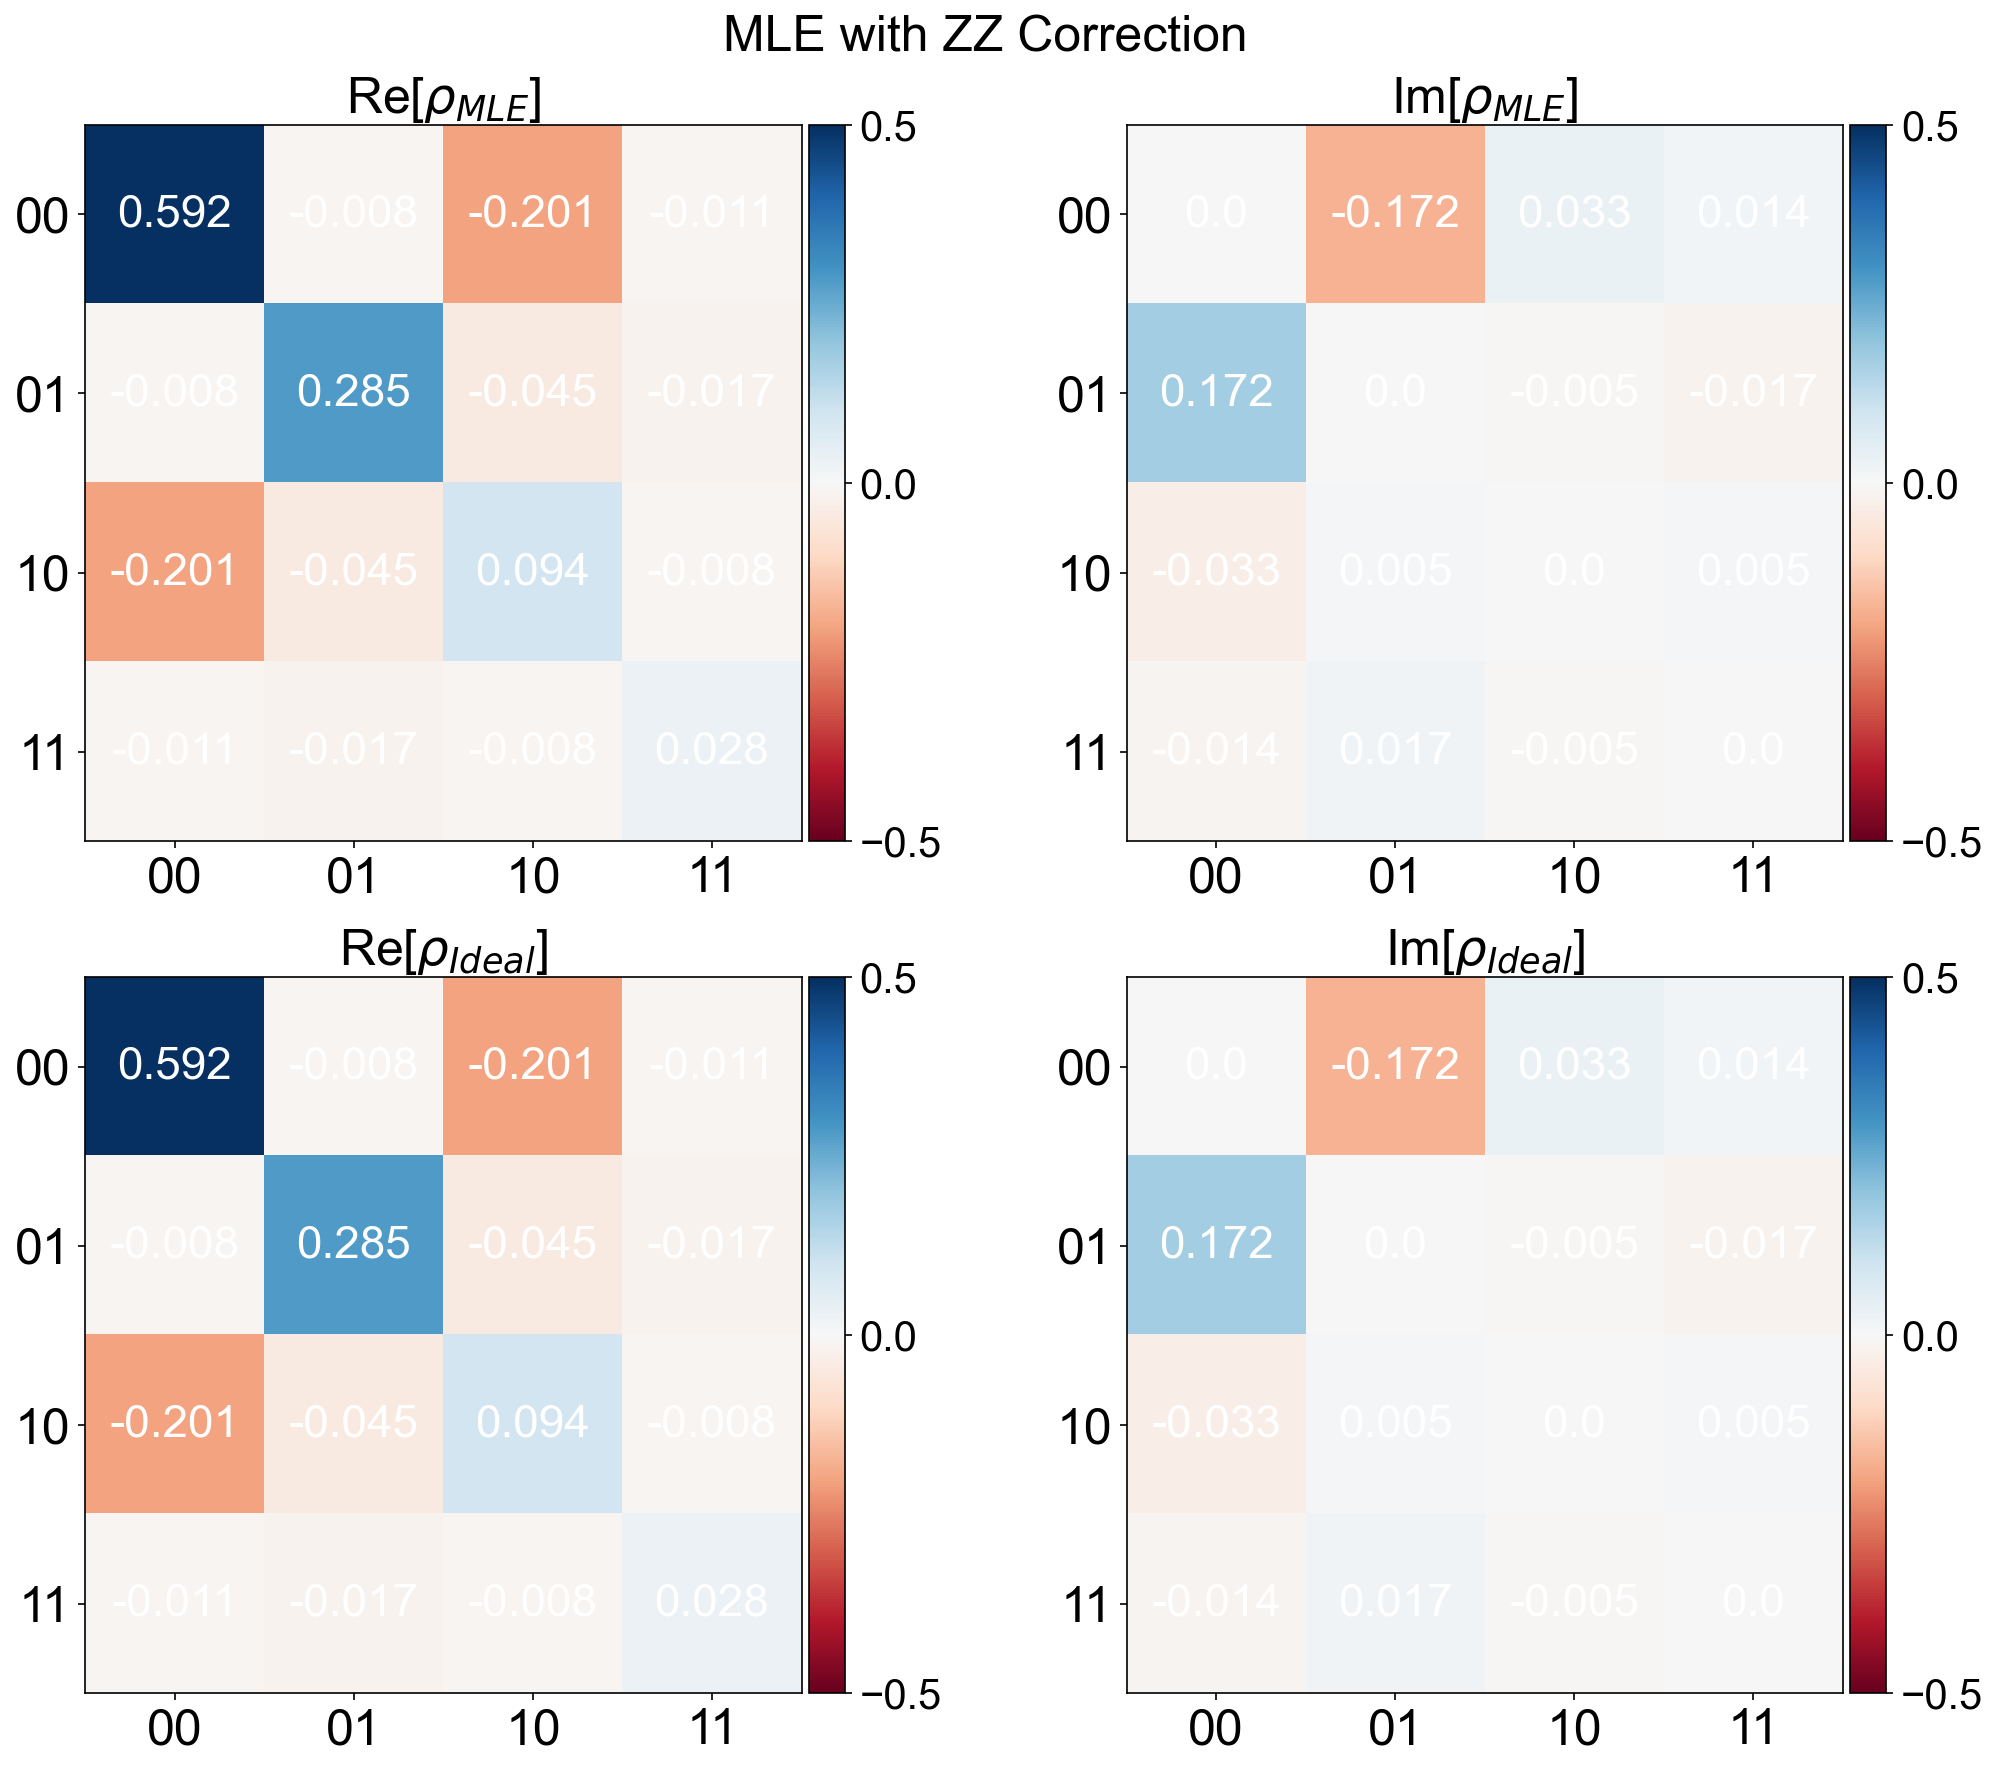

In [234]:
rho_MLE_ZZ = qt.Qobj(inpt=np.array( # |1>|0+1> input, forward simulation smaller amps, averaged pi pulses, q2/q3
[[ 0.592+0.j   , -0.008-0.172j, -0.201+0.033j, -0.011+0.014j],
 [-0.008+0.172j,  0.285+0.j   , -0.045-0.005j, -0.017-0.017j],
 [-0.201-0.033j, -0.045+0.005j,  0.094+0.j   , -0.008+0.005j],
 [-0.011-0.014j, -0.017+0.017j, -0.008-0.005j,  0.028+0.j   ]]),
                 dims=rho_id.dims, shape=rho_id.shape)
show_plot_rho_2d(rho_MLE_ZZ, rho_id, title='MLE with ZZ Correction', savetitle=savetitle, cmax=0.5)

100%|██████████| 75/75 [00:17<00:00,  4.27it/s]


Improved fidelity by (%) 45.406558449540505
Fidelity (after rotation): 0.8906153821621464
Purity (after rotation): 0.5903290530921799
Target purity: 0.6249999973968745
Best rotation: [180.0, 102.16216216216218]
[[ 0.592+0.j    -0.008-0.172j -0.201+0.033j -0.011+0.014j]
 [-0.008+0.172j  0.285+0.j    -0.045-0.005j -0.017-0.017j]
 [-0.201-0.033j -0.045+0.005j  0.094+0.j    -0.008+0.005j]
 [-0.011-0.014j -0.017+0.017j -0.008-0.005j  0.028+0.j   ]]


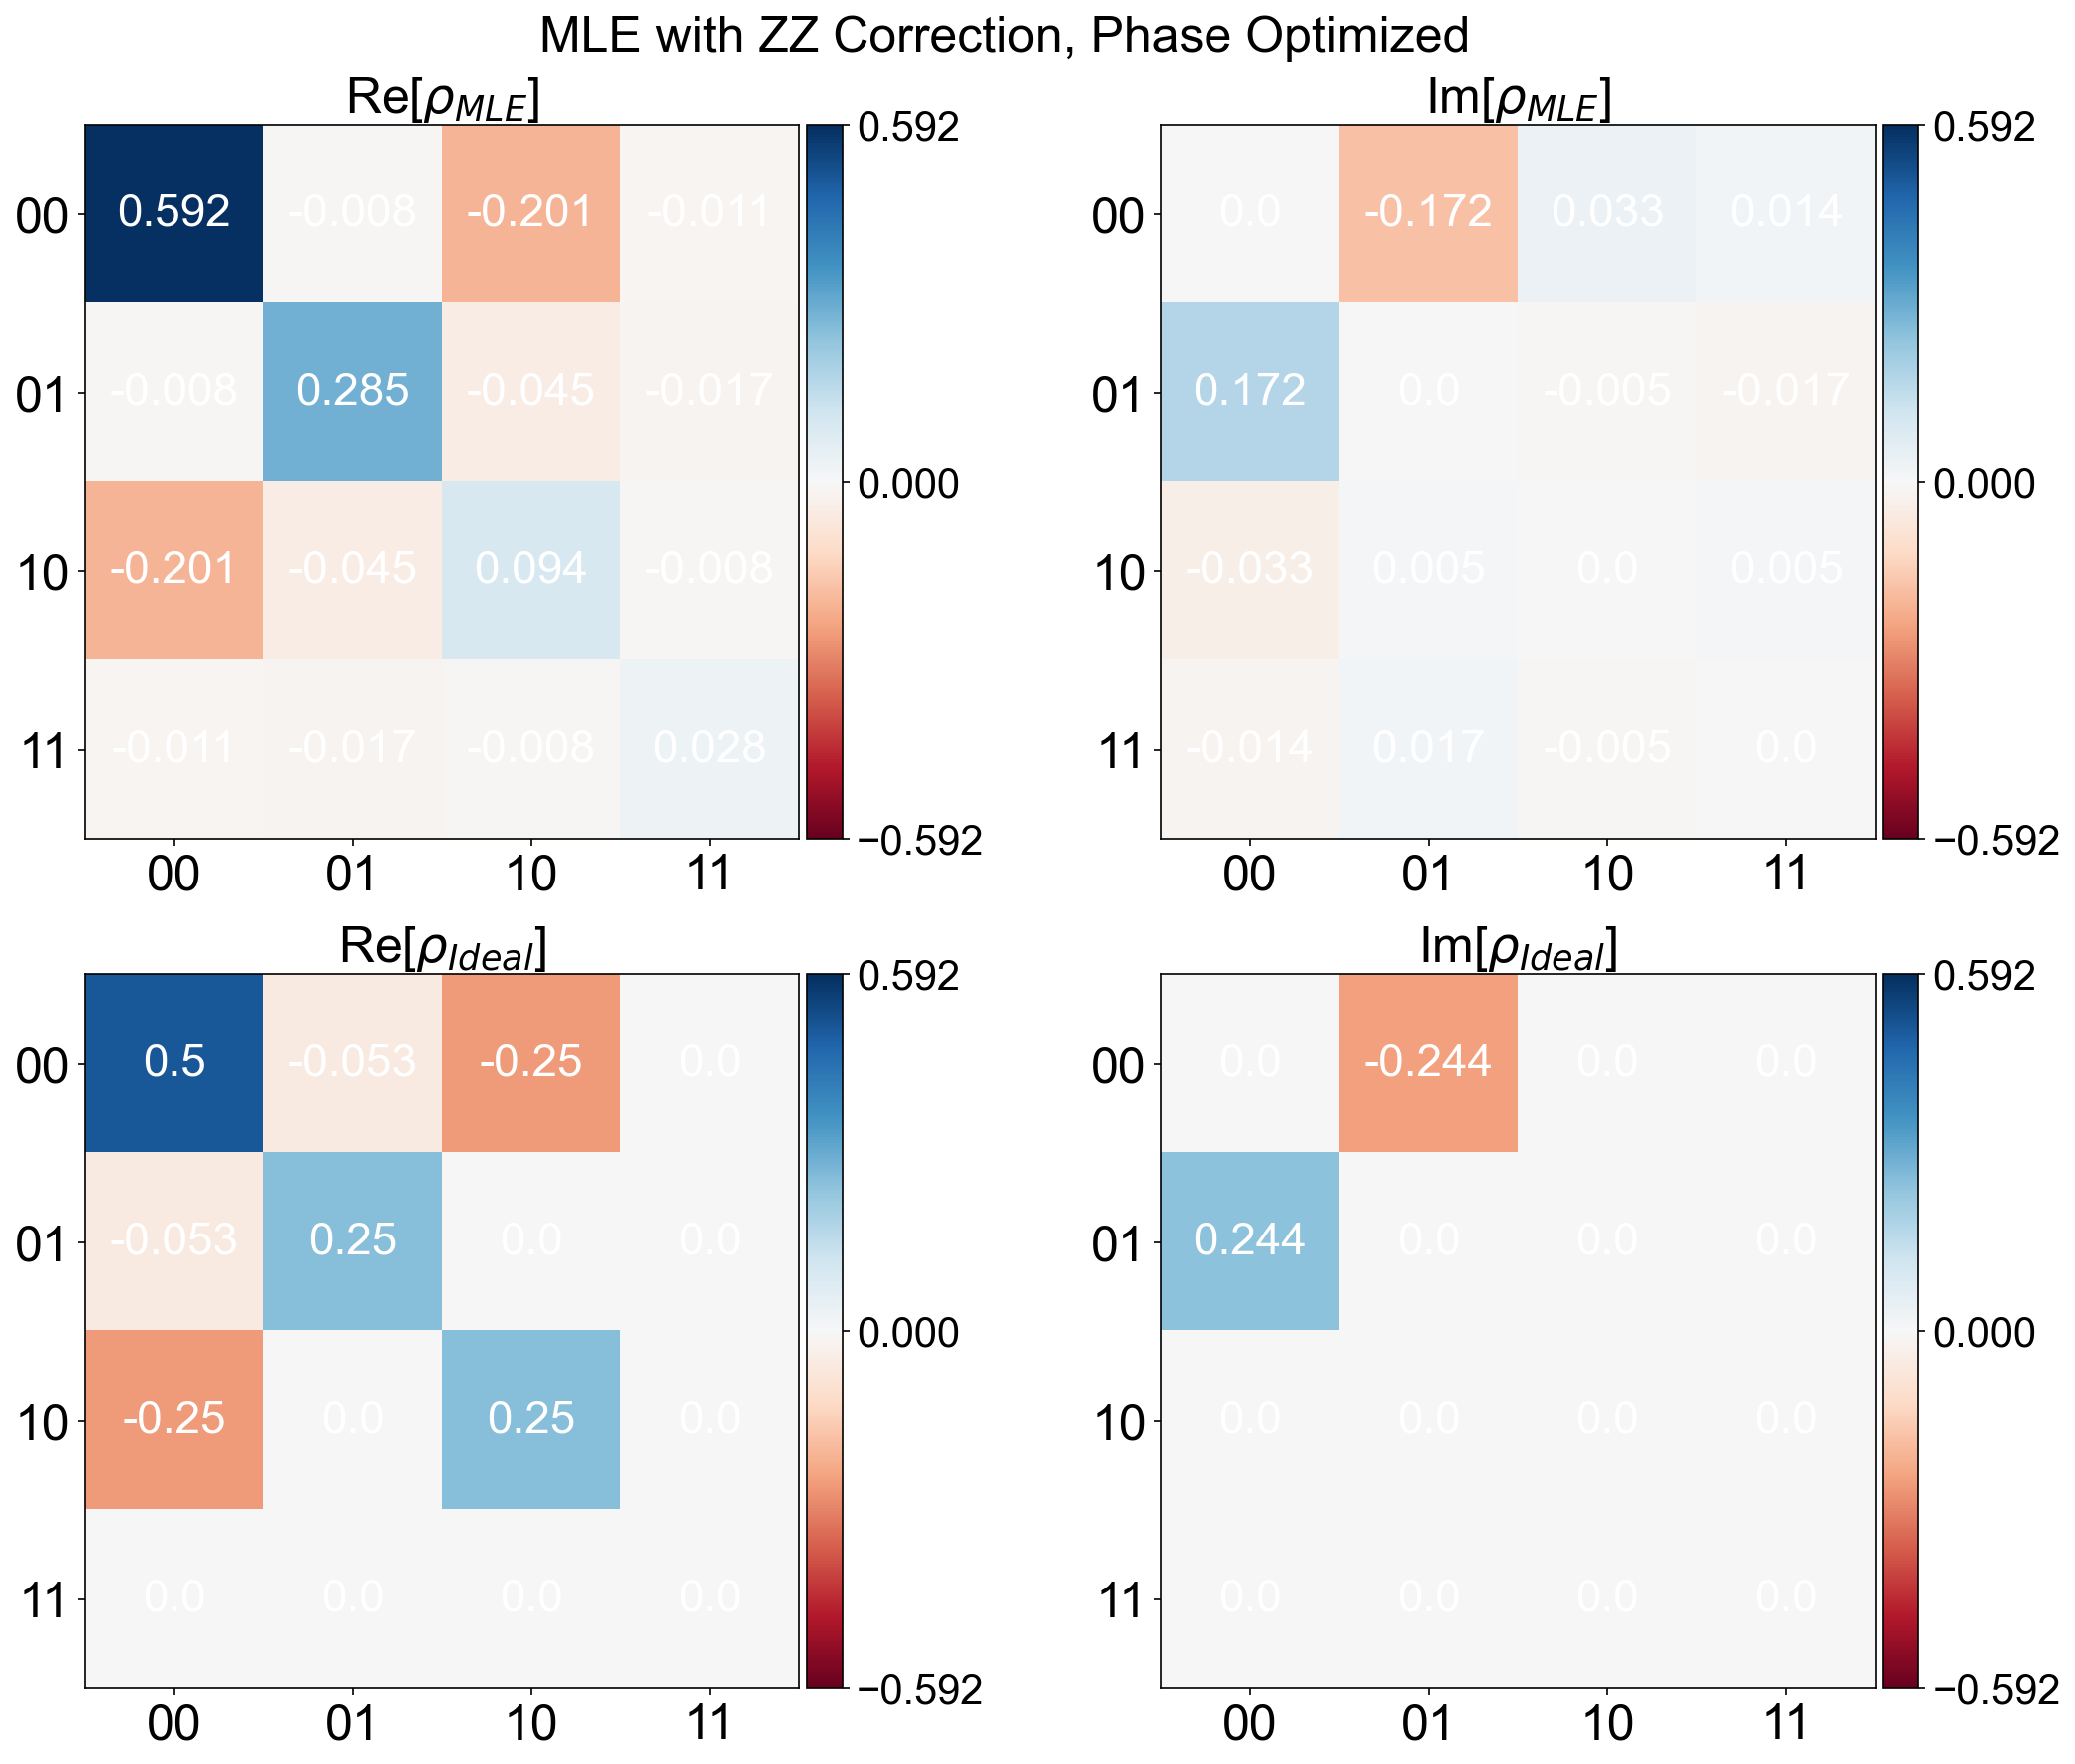

In [213]:
rho_id_rot, best_phis, best_fid = opt_virtualZ_MLE(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id, nphi=75)

fid_ZZ_rot = best_fid
purity_ZZ_rot = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id_rot = np.real(np.trace(rho_id_rot.full() @ rho_id_rot.full()))
print(f'Fidelity (after rotation): {fid_ZZ_rot}')
print(f'Purity (after rotation): {purity_ZZ_rot}')
print(f'Target purity: {purity_id_rot}')
print(f'Best rotation: {best_phis}')

print(np.around(rho_MLE_ZZ, decimals=3))
show_plot_rho_2d(rho_MLE_ZZ, rho_id_rot, title='MLE with ZZ Correction, Phase Optimized') #, cmax=1.0)

In [337]:
# tomo.save_data()